## start

In [5]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import optuna
from tqdm import tqdm
from scipy import stats
import joblib

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import re

In [3]:
from perform_visualization import perform_eda, perform_eda_short, performance_visualizations

In [4]:
random_seed = 42
early_stopping_round = 100

## funcs

In [6]:
def get_dataset(folder_paths: list, filename_features: str, filename_target: str):
    X = pd.DataFrame()
    y = pd.DataFrame()
    for folder in folder_paths:
        X_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_features)
        y_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_target)
        
        is_unnamed = pd.isna(X_tmp.columns[0]) or str(X_tmp.columns[0]).startswith('Unnamed:')
        is_unnamed_y = pd.isna(y_tmp.columns[0]) or str(y_tmp.columns[0]).startswith('Unnamed:')
        if is_unnamed:
            X_tmp = X_tmp.drop(X_tmp.columns[0], axis=1)
        if is_unnamed_y:
            y_tmp = y_tmp.drop(y_tmp.columns[0], axis=1)
        
        # if X_tmp.columns[0] != "y":
        #     col_y = np.ones(X_tmp.shape[0]) * 1000
        #     X_tmp.insert(0, "y", col_y)
        
        print(X_tmp.shape, y_tmp.shape)
        X = pd.concat([X, X_tmp], axis = 0)
        y = pd.concat([y, y_tmp], axis = 0)
    X.reset_index(inplace=True, drop=True)
    y.reset_index(inplace=True, drop=True)
    print(X.shape, y.shape)
    return X, y

In [7]:
def add_exp_num(X):
    distances_num = len(np.unique(X["distances"]))
    experiment_num = []
    tracer_old = 0
    idx_glob = 1
    tmp = []
    for idx in range(0, X.shape[0], distances_num):
        tracer = X.loc[idx, "Tracer"]
        if tracer < tracer_old:
            experiment_num.extend(tmp * distances_num)
            tmp.clear()
            idx_glob +=1
            tracer_old = tracer
            tmp.append(idx_glob)
        else:
            tracer_old = tracer
            tmp.append(idx_glob)
    experiment_num.extend(tmp * distances_num)
    X["experiment_num"] = experiment_num
    return X

In [8]:
def data_split(X, y, test_size = 0.2, valid_size = None, eval_size = None, random_seed = random_seed):
    rng = np.random.default_rng(seed=random_seed)
    
    experiment_nums = X["experiment_num"].unique()
    total_experiments = len(experiment_nums)
    
    n_test = int(test_size * total_experiments)
    
    splits = {}
    remaining_exps = set(experiment_nums)
    
    test_experiments = set(rng.choice(list(remaining_exps), n_test, replace=False))
    remaining_exps -= test_experiments
    splits['test'] = {
        'X': X[X["experiment_num"].isin(test_experiments)].copy(),
        'y': None
    }
    
    if valid_size:
        n_valid = int(valid_size * (total_experiments - n_test))
        valid_experiments = set(rng.choice(list(remaining_exps), n_valid, replace=False))
        remaining_exps -= valid_experiments
        splits['valid'] = {
            'X': X[X["experiment_num"].isin(valid_experiments)].copy(),
            'y': None
        }
    
    if eval_size:
        n_eval = int(eval_size * (total_experiments - n_test - n_valid))
        eval_experiments = set(rng.choice(list(remaining_exps), n_eval, replace=False))
        remaining_exps -= eval_experiments
        
        splits['eval'] = {
            'X': X[X["experiment_num"].isin(eval_experiments)].copy(),
            'y': None
        }
    
    splits['train'] = {
        'X': X[X["experiment_num"].isin(remaining_exps)].copy(),
        'y': None
    }
    
    for split_name in splits:
        splits[split_name]['y'] = y.loc[splits[split_name]['X'].index].copy()
    
    split_shapes = [f"{name}: X{splits[name]['X'].shape}, y{splits[name]['y'].shape}" 
                   for name in ['train', 'test', 'valid', 'eval'] 
                   if name in splits]
    print(f"Split shapes: {', '.join(split_shapes)}")
    
    if valid_size and eval_size:
        return (splits['train']['X'], splits['test']['X'], splits['valid']['X'], splits['eval']['X'],
                splits['train']['y'], splits['test']['y'], splits['valid']['y'], splits['eval']['y'])
    elif valid_size:
        return (splits['train']['X'], splits['test']['X'], splits['valid']['X'],
                splits['train']['y'], splits['test']['y'], splits['valid']['y'])
    else:
        return splits['train']['X'], splits['test']['X'], splits['train']['y'], splits['test']['y']

In [9]:
def del_outs(X, y):
    #Delete zeros
    mask = (y["c_std_y"] != 0) & (y["c_std_z"] != 0)
    X = X[mask]
    y = y[mask]
    points = np.linspace(0, np.max(y["c_std_y"]), 200)
    quantiles = np.histogram(y["c_std_y"], points)
    hist_mode = quantiles[1][np.argmax(quantiles[0])]
    cut_mask = y["c_std_y"] >= hist_mode
    X = X[cut_mask]
    y = y[cut_mask]
    print(X.shape, y.shape)
    return X, y

In [10]:
def make_means_target(X, y):
    y["c_mean_y"] = X["y"] - y["c_mean_y"]
    y["c_mean_z"] = X["z"] - y["c_mean_z"]
    return y

In [11]:
def del_columns(X, columns):
    X.drop(columns=columns, inplace=True)
    # return X


## begin

In [12]:
stat_path = os.path.join(os.getcwd())
pattern = re.compile(r'output_*\d')
folder_paths =[]
for folder_name in os.listdir(stat_path):
    if pattern.match(folder_name):
        folder_paths.append(folder_name)

In [13]:
specific_features= pd.DataFrame({"y": [500.0],
                                "z": [156.25],
                                "u": [7.5],
                                "power":[1.1],
                                "roughness": [0.1],
                                "T": [241.0],
                                "sensible_heat_flux":[-0.35],
                                "T_grad":[0.03],
                                "distances": [1054.6875]})

In [14]:
filename_features = "features_full.csv"
filename_target = "target_full.csv"

In [29]:
folder_paths = ["output_19_01_2025_2", "output_21_03_2025", "output_31_03_2025"] # "output_31_03_2025"
# folder_paths = ["output_21_03_2025"]
# folder_paths = ["output_31_03_2025"]

In [30]:
X, y = get_dataset(folder_paths, filename_features, filename_target)

(2322432, 10) (2322432, 4)
(2457600, 10) (2457600, 4)
(556800, 10) (556800, 4)
(5336832, 10) (5336832, 4)


In [31]:
y = make_means_target(X, y)

In [32]:
y.rename(columns={"c_mean_y": "c_delta_y", "c_mean_z": "c_delta_z"}, inplace=True)

In [33]:
X = add_exp_num(X)

## Delete zeros

In [34]:
X, y = del_outs(X, y)

(5068961, 11) (5068961, 4)


## EDA

In [ ]:
perform_eda(X[X.columns[1:-1]], y)

## Test-train split

In [35]:
# X_train, X_test, X_valid, X_eval, y_train, y_test, y_valid, y_eval = data_split(X, y, test_size=0.2, valid_size=0.2, eval_size=0.1)
X_train, X_test, X_eval, y_train, y_test, y_eval = data_split(X, y, test_size=0.2, valid_size=0.1)

Split shapes: train: X(3650568, 11), y(3650568, 4), test: X(1024138, 11), y(1024138, 4), valid: X(394255, 11), y(394255, 4)


In [36]:
del_columns(X_train, ["experiment_num", "Tracer"])
del_columns(X_test, ["experiment_num", "Tracer"])
# del_columns(X_valid, ["experiment_num", "Tracer"])
del_columns(X_eval, ["experiment_num", "Tracer"])

In [23]:
# X_part, X_test, y_part, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [24]:
# X_train, X_valid, y_train, y_valid = train_test_split(X_part, y_part, test_size=0.2, random_state=random_seed)
# X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

In [25]:
# for small dataset
# X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
# X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=random_seed)

In [26]:
# for small dataset
# X_train.shape, y_train.shape, X_eval.shape, y_eval.shape

In [27]:
# X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_eval.shape, y_eval.shape

In [28]:
# perform_eda_short(X_test, y_test)

In [29]:
# X_test_cut = X_test[X_test["distances"] > 490].copy()
# y_test_cut = y_test.loc[X_test_cut.index]
# X_train_cut = X_train[X_train["distances"] > 490].copy()
# y_train_cut = y_train.loc[X_train_cut.index] 

## Feature engineering

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import quantile_transform, power_transform

In [38]:
class TargetPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, near_zero = 1e-3):
        self.near_zero = near_zero

    def fit(self, data: pd.DataFrame, *args):
        self.columns = data.columns
        self.std_y_bias = np.min(data["c_std_y"])
        self.std_z_bias = np.min(data["c_std_z"])
        
        self.std_y_std = np.std(data["c_std_y"])
        self.std_z_std = np.std(data["c_std_z"])

        self.mean_y_mean = np.mean(data["c_delta_y"])
        self.mean_z_mean = np.mean(data["c_delta_z"])

        self.mean_y_std = np.std(data["c_delta_y"])
        self.mean_z_std = np.std(data["c_delta_z"])

        self.mean_y_minuses = data.index[data["c_delta_y"] < 0].to_list()
        self.mean_z_minuses = data.index[data["c_delta_z"] < 0].to_list()

        return self

    def transform(self, data: pd.DataFrame):
        data["c_std_y"] -= self.std_y_bias - self.near_zero
        data["c_std_z"] -= self.std_z_bias - self.near_zero
        data["c_std_y"] = np.log(data["c_std_y"])
        data["c_std_z"] = np.log1p(data["c_std_z"])
        
        mean_y_sign = np.sign(data["c_delta_y"])
        data["c_delta_y"] = np.abs(data["c_delta_y"])       
        data["c_delta_y"] = np.log1p(data["c_delta_y"])
        # data["c_delta_y"] = np.log(data["c_delta_y"] + 1e-6)
        data["c_delta_y"]*=mean_y_sign
        
        data["c_delta_z"] = (data["c_delta_z"] - self.mean_z_mean)/self.mean_z_std
        mean_z_sign = np.sign(data["c_delta_z"])
        data["c_delta_z"]= mean_z_sign * np.log1p(np.abs(data["c_delta_z"]))
        # data["c_delta_z"]= mean_z_sign * np.log(np.abs(data["c_delta_z"]) + 1e-6)
        
        return data
    
    def inverse_transform(self, data: pd.DataFrame):
        if type(data) != pd.DataFrame:
            data = pd.DataFrame(data)
            
        if "c_std_y" in data.columns:
            data["c_std_y"] = np.exp(data["c_std_y"])
            data["c_std_y"] += self.std_y_bias - self.near_zero

        if "c_std_z" in data.columns:
            data["c_std_z"] = np.expm1(data["c_std_z"])
            data["c_std_z"] += self.std_z_bias - self.near_zero
        
        if "c_delta_y" in data.columns:
            mean_y_sign = np.sign(data["c_delta_y"])
            data["c_delta_y"] = np.abs(data["c_delta_y"])
            data["c_delta_y"] = np.expm1(data["c_delta_y"])
            data["c_delta_y"] *=mean_y_sign
        if "c_delta_z" in data.columns:
            mean_z_sign = np.sign(data["c_delta_z"])
            data["c_delta_z"] = np.expm1(np.abs(data["c_delta_z"]))
            data["c_delta_z"] *=mean_z_sign
            data["c_delta_z"] = data["c_delta_z"] * self.mean_z_std + self.mean_z_mean
        return data


In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
scaler = StandardScaler()
X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.transform(X_test)
X_eval_n = scaler.transform(X_eval)


In [52]:
# y_train_1 = y_train.copy()
# target_pr = TargetPreprocessor()
# target_pr.fit(y_train_1)
# target_pr.transform(y_train_1)
# y_eval_1 = y_eval.copy()
# target_pr.transform(y_eval_1)
# target_pr.transform(y_valid)

array([[<Axes: title={'center': 'c_delta_z'}>,
        <Axes: title={'center': 'c_delta_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

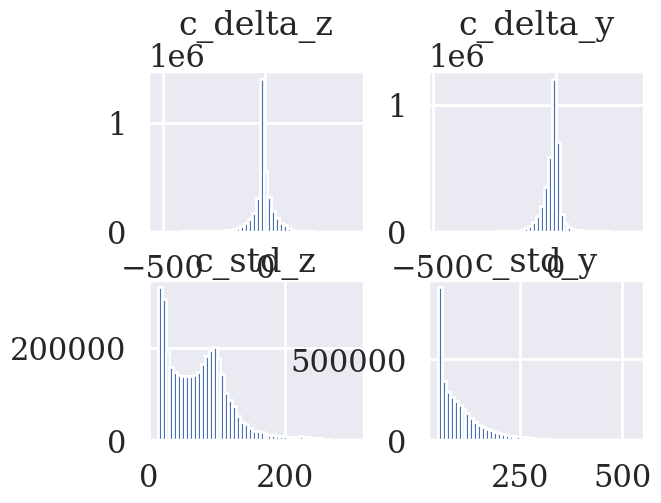

In [41]:
y_train.hist(bins=50)

In [47]:
y_1 = y_train.copy()

In [48]:
t_preproc = TargetPreprocessor()
# t_preproc.fit(y)
t_preproc.fit(y)
y_1 = t_preproc.transform(y_1)
print()
# perform_eda_short(X_train, y_train)

In [49]:
# t_preproc.fit(y)
y_eval = t_preproc.transform(y_eval)

In [57]:
# y_1.isna().sum()

In [58]:
# t_preproc.inverse_transform(y_1)
# print()

array([[<Axes: title={'center': 'c_delta_z'}>,
        <Axes: title={'center': 'c_delta_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

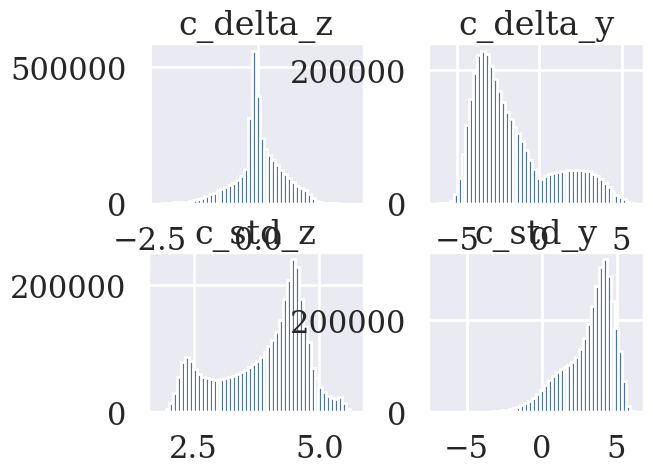

In [44]:
y_1.hist(bins=50)

In [45]:
t_preproc.inverse_transform(y_1)

,c_delta_z,c_delta_y,c_std_z,c_std_y
1,-17.501329,0.103249,15.888194,50.499219
3,-17.556482,0.087350,15.981372,50.500784
47,-17.801546,8.404837,18.843160,50.491930
48,-17.690109,8.780635,18.807543,50.538909
49,-17.816673,8.939117,18.698380,50.665808
...,...,...,...,...
5336827,21.395054,-76.599228,102.841963,191.824317
5336828,21.204700,-76.452529,102.737056,192.461170
5336829,20.253417,-75.704193,102.772327,194.606844
5336830,20.005640,-75.670691,102.714813,195.131626


array([[<Axes: title={'center': 'c_delta_z'}>,
        <Axes: title={'center': 'c_delta_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

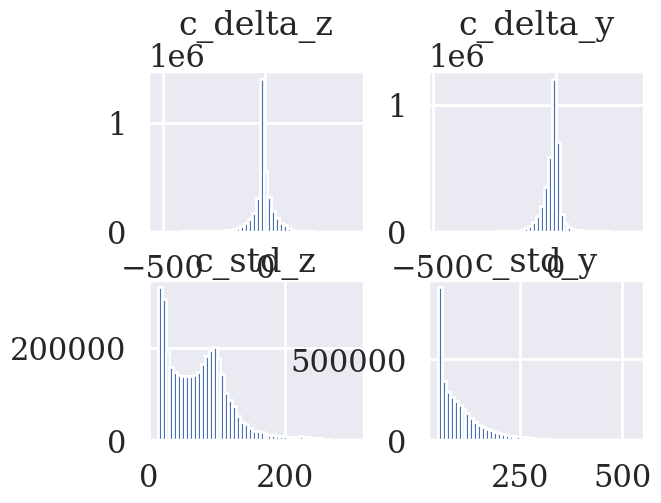

In [46]:
y_1.hist(bins=50)

In [165]:
np.sum(np.abs(y_train - y_1), axis=0) 

c_delta_z    7.627618e-09
c_delta_y    1.209187e-08
c_std_z      4.173326e-08
c_std_y      3.135054e-08
dtype: float64

In [61]:
# y_train.hist(bins=50)

In [62]:
# t_preproc.transform(y_eval)
# t_preproc.transform(y_valid)

In [63]:
# perform_eda_short(X_train, y_train)

In [64]:
# (y_train <= 0).sum(), (y_train > 0).sum() 

In [65]:
# y_train

## Models

## Catboost with optuna

In [21]:
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.02),
        'depth': trial.suggest_int('depth', 1, 16),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 3.0),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'grow_policy': 'SymmetricTree',
        'iterations': 300,
        'use_best_model': True,
        'eval_metric': 'MultiRMSE',
        'loss_function': 'MultiRMSE',
        'od_type': 'iter',
        'task_type': "GPU",
        # 'devices': '0',
        'od_wait': 20,
        'random_state': random_seed,
        'logging_level': 'Silent'
    }
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())],
                  early_stopping_rounds=early_stopping_round)
    loss = root_mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
    return loss

In [ ]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{random_seed}')
study.optimize(objective, n_trials=1000, timeout=7200)

In [ ]:
print(study.best_value)
print(study.best_params)

In [13]:
best_params = {'learning_rate': 0.0199640131584563, 'depth': 15, 'l2_leaf_reg': 1.8809696508799658, 'min_child_samples': 16}

In [14]:
params = {
    "learning_rate": best_params['learning_rate'],
    "depth": best_params['depth'],
    "l2_leaf_reg": best_params['l2_leaf_reg'],
    "min_child_samples": best_params['min_child_samples'],
    "grow_policy": 'Depthwise',
    "iterations": 1000,
    "use_best_model": True,
    "eval_metric": 'RMSE',
    "loss_function": 'RMSE',
    # "thread_count": -1,
    "od_type": 'iter',
    "od_wait": 20,
    "task_type":"GPU",
    # "devices":'0',
    "random_state": random_seed,
    "logging_level": 'Silent'
}   

In [15]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
%%time
y_pred ={}
regressors = {}
for target in ["c_mean_y", "c_mean_z"]:
    
    optimized_regressor = CatBoostRegressor(**params)

    optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp
    regressors[target] = optimized_regressor
for target in ["c_std_y", "c_std_z"]:
    
    optimized_regressor = CatBoostRegressor(**params)
    
    optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp
    regressors[target] = optimized_regressor

In [ ]:
t_preproc.inverse_transform(y_pred)
performance_visualizations(y_pred, y_test)

In [ ]:
pd.DataFrame.from_dict(y_pred).hist(bins=100)

In [66]:
print(regressors["c_mean_y"].predict(specific_features))
print(regressors["c_std_y"].predict(specific_features))

[971.24424704]
[4.46791407]


## find_weights

In [50]:
weights = {}
for target in y_train.columns:
    points = np.linspace(np.min(y[target]), np.max(y[target]), 201)
    density, bin_edges = np.histogram(y_train[target], bins=points)
    bin_indices = np.digitize(y_train[target], bin_edges) - 1    
    density_answ = []
    # density = np.log1p(density.astype(float))
    for i in density:
        if i !=0:
            density_answ.append(1.0/i)
        else:
            density_answ.append(0)
    density = np.array(density_answ)
    # plt.scatter(bin_edges[:-1],density)
    # plt.show() 
    # Clip to handle edge cases
    bin_indices = np.clip(bin_indices, 0, len(density) - 1)
    # Assign density values to each element based on its bin
    element_weights = density[bin_indices]

    weights[target] = element_weights 
    

## Random Forest

In [ ]:
# import cuml.patch и cuml.patch.apply()

In [152]:
model_rf = RandomForestRegressor(n_jobs=64)

In [51]:
y_pred = {}
model_rf_dict = {}
for target in y_train.columns:
    model_rf_dict[target] = RandomForestRegressor(n_jobs=64)
    # model_rf_dict[target].fit(X_train, y_train[target])
    model_rf_dict[target].fit(X_train_n, y_1[target])
    # model_rf_dict[target].fit(X_train_n, y_1[target], sample_weight = weights[target])
    # model_rf_dict[target].fit(X_train_cut, y_1[target])
    # y_tmp = model_rf_dict[target].predict(X_test_cut)
    y_tmp = model_rf_dict[target].predict(X_test_n)
    y_pred[target] = y_tmp

In [52]:
y_test_1 = y_test.copy()

In [53]:
y_test_1 = t_preproc.transform(y_test_1)

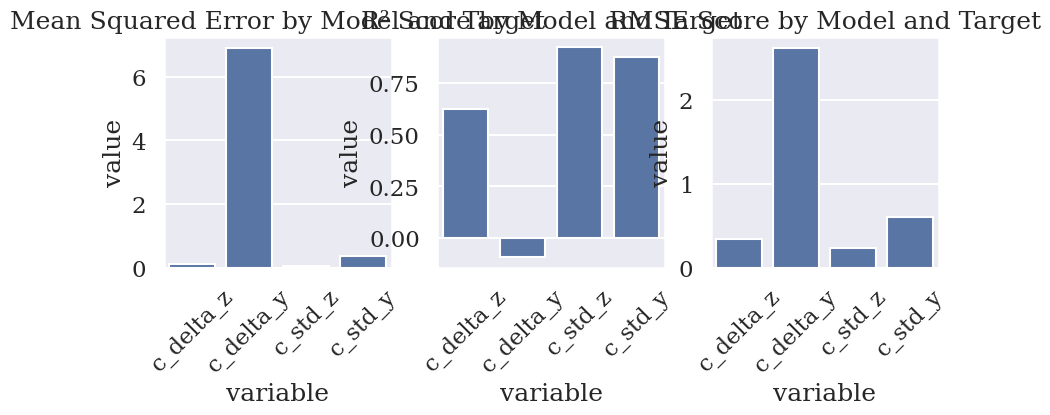

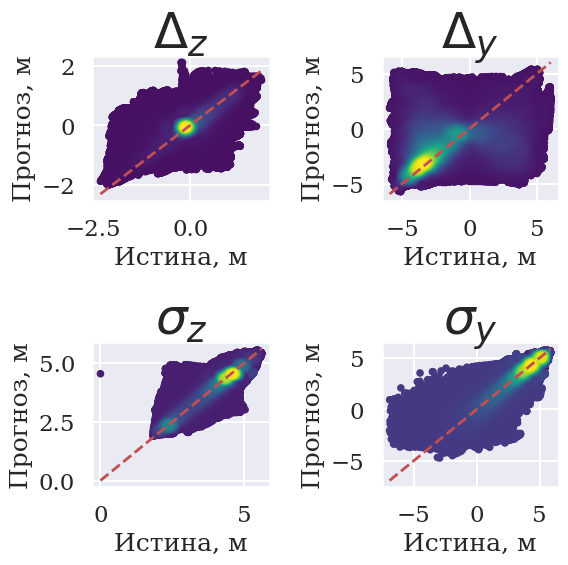

                mse        r2      rmse
c_delta_z  0.119120  0.627761  0.345137
c_delta_y  6.914090 -0.093472  2.629466
c_std_z    0.053331  0.925376  0.230935
c_std_y    0.369440  0.875525  0.607816


In [55]:
# t_preproc.inverse_transform(y_pred)
performance_visualizations(y_pred, y_test_1)

array([[<Axes: title={'center': 'c_delta_z'}>,
        <Axes: title={'center': 'c_delta_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

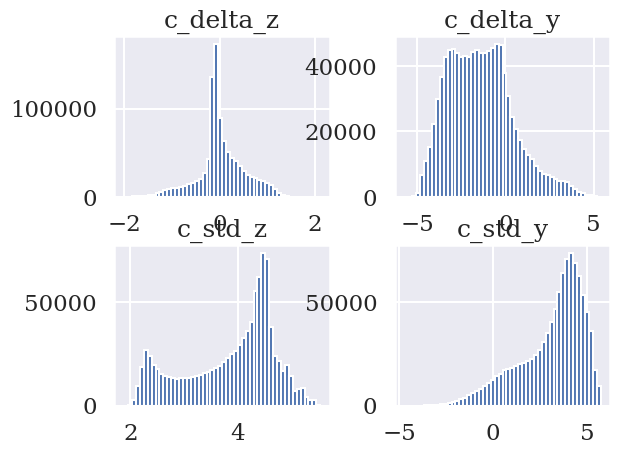

In [56]:
pd.DataFrame(y_pred).hist(bins=50)

array([[<Axes: title={'center': 'c_delta_z'}>,
        <Axes: title={'center': 'c_delta_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

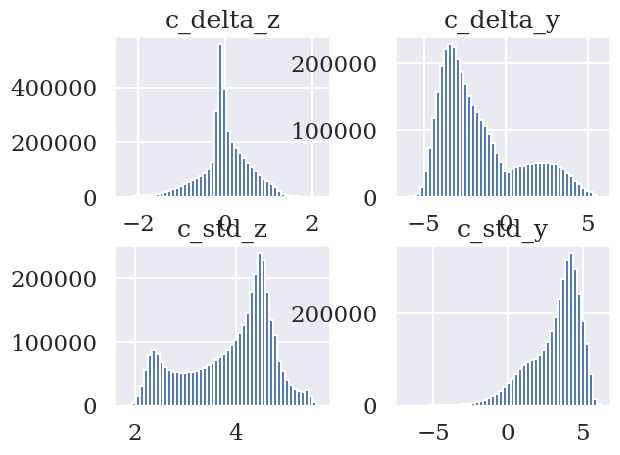

In [57]:
pd.DataFrame(y_1).hist(bins=50)

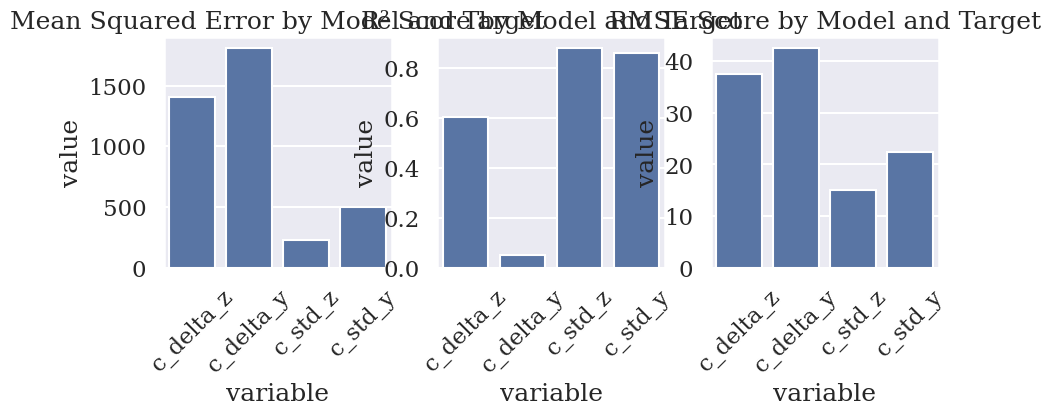

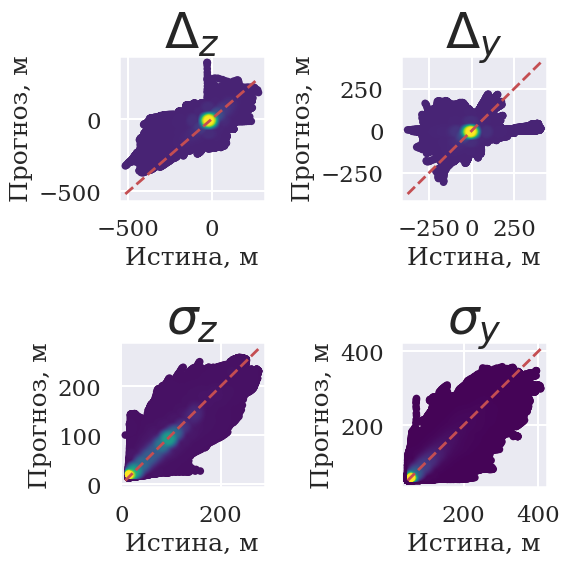

                   mse        r2       rmse
c_delta_z  1408.481577  0.604424  37.529743
c_delta_y  1813.126942  0.049045  42.580828
c_std_z     227.082405  0.879648  15.069254
c_std_y     502.122787  0.860025  22.408096


In [58]:
y_pred = t_preproc.inverse_transform(pd.DataFrame(y_pred))
performance_visualizations(y_pred, y_test)

## RF Feature Importance

In [41]:
import shap

In [42]:
X_test_n_pd = pd.DataFrame(data=X_test_n, columns=X_test.columns)

In [ ]:

# for target in y_train.columns:
#     explainer = shap.Explainer(model_rf_dict[target], X_test_n_pd)
#     shap_values = explainer(X_test_n_pd)
#     shap.plots.bar(shap_values, show=False)
#     plt.savefig(target +"f_i.png")

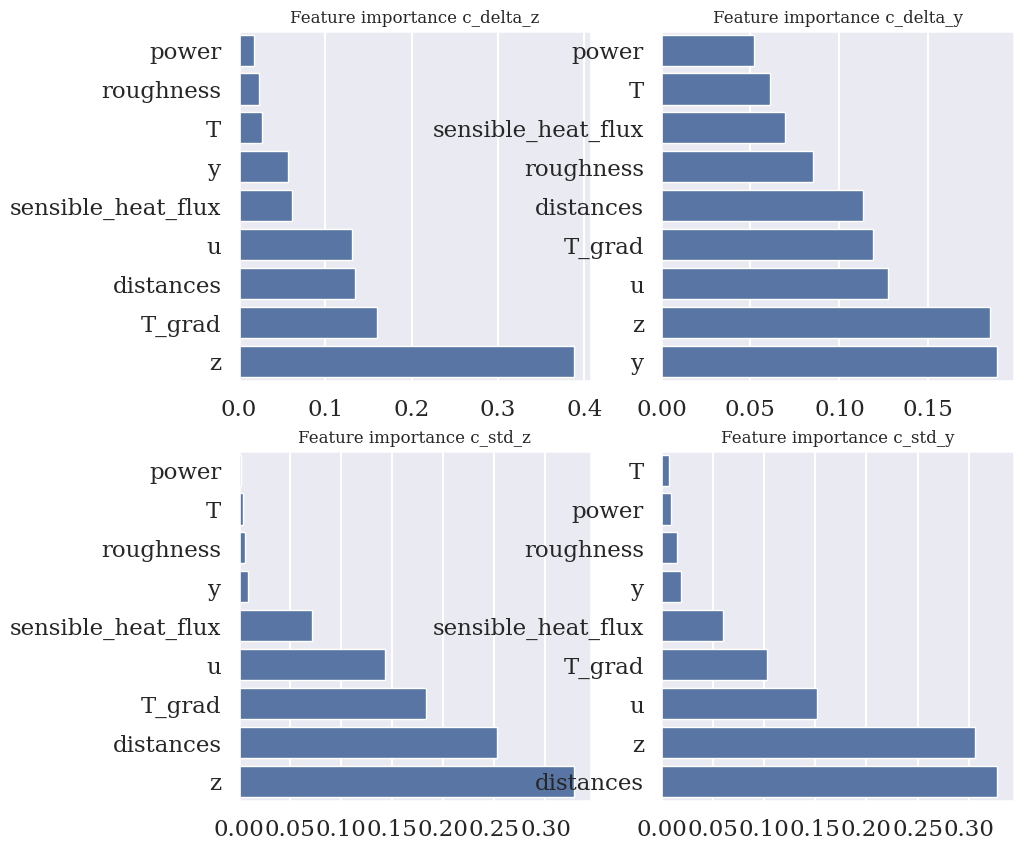

In [43]:
shape_col_t = 2        
shape_row_t = 2
fig, axes = plt.subplots(shape_row_t, shape_col_t, figsize=(10, 10)) 
sns.set_theme(style="whitegrid")

for idx, col in enumerate(y_train.columns):
    row = idx // shape_col_t
    col_idx = idx % shape_row_t
    feature_importance = model_rf_dict[col].feature_importances_
    feature_importance_pd = pd.Series(feature_importance, index=X_train.columns)
    feature_importance_pd.to_csv("feature_importance_rf_" + col+".csv")
    sorted_idx = np.argsort(feature_importance)
    sns.barplot(x = feature_importance[sorted_idx], y=np.array(X_test.columns)[sorted_idx], ax=axes[row, col_idx])
    # axes[row, col_idx].set_yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    axes[row, col_idx].set_title(f'Feature importance {col}')


## Do it for means

In [ ]:
# y_pred = pd.DataFrame(y_pred).copy()
# y_pred.rename(columns={"c_mean_y": "c_delta_y", "c_mean_z": "c_delta_z"}, inplace=True)
# y_test_1.rename(columns={"c_mean_y": "c_delta_y", "c_mean_z": "c_delta_z"}, inplace=True)
# y_test_1["c_mean_y"] += X_test_cut.loc[y_test_1.index, "y"]
# y_pred["c_mean_y"] += X_test_cut.loc[y_test_1.index, "y"]

## -------------

In [ ]:
y_test.hist(bins=50)

In [ ]:
pd.DataFrame(y_pred).hist(bins=50)

## split distances

In [ ]:
# folder_paths = ["output_19_01_2025_2"]
filename_features_cut = "features.csv"
filename_target_23_4375 = "target-23_4375.csv"
filename_target_492_1875 = "target-492_1875.csv"
filename_target_1492_1875 = "target-1492_1875.csv"

In [49]:
features_23_4375, y_test_23_4375 = get_dataset(folder_paths, filename_features_cut, filename_target_23_4375)
features_492_1875, y_test_492_1875 = get_dataset(folder_paths, filename_features_cut, filename_target_492_1875)
features_1492_1875, y_test_1492_1875 = get_dataset(folder_paths, filename_features_cut, filename_target_1492_1875)

(24192, 9) (24192, 4)
(24192, 9) (24192, 4)
(24192, 9) (24192, 4)
(24192, 9) (24192, 4)
(24192, 9) (24192, 4)
(24192, 9) (24192, 4)


In [ ]:
plt.scatter(np.arange(1, len(y_test_23_4375["c_mean_y"]) +1), y_test_23_4375["c_mean_y"], color="r", alpha=0.5)
plt.scatter(np.arange(1, len(y_test_492_1875["c_mean_y"]) +1), y_test_492_1875["c_mean_y"], color="b", alpha=0.5)
plt.scatter(np.arange(1, len(y_test_1492_1875["c_mean_y"]) +1), y_test_1492_1875["c_mean_y"], color="g",alpha=0.5)

In [55]:
features_23_4375.drop(columns="Tracer", inplace=True)
features_492_1875.drop(columns="Tracer", inplace=True)
features_1492_1875.drop(columns="Tracer", inplace=True)

features_23_4375["distances"] = np.ones(features_23_4375.shape[0]) * 23.4375
features_492_1875["distances"] = np.ones(features_492_1875.shape[0]) * 492.1875
features_1492_1875["distances"] = np.ones(features_1492_1875.shape[0]) * 1492.1875


In [56]:
def del_zeros(X:pd.DataFrame, y: pd.DataFrame):
    #Delete zeros
    mask = (y["c_std_y"] != 0) & (y["c_std_z"] != 0)
    X = X[mask]
    y = y[mask]
    points = np.linspace(0, np.max(y["c_std_y"]), 200)
    quantiles = np.histogram(y["c_std_y"], points)
    hist_mode = quantiles[1][np.argmax(quantiles[0])]
    cut_mask = y["c_std_y"] >= hist_mode
    X = X[cut_mask]
    y = y[cut_mask]
    print(X.shape, y.shape)
    return X, y

In [57]:
features_23_4375, y_test_23_4375 = del_zeros(features_23_4375, y_test_23_4375)
features_492_1875, y_test_492_1875 = del_zeros(features_492_1875, y_test_492_1875)
features_1492_1875, y_test_1492_1875 = del_zeros(features_1492_1875, y_test_1492_1875)


(23752, 9) (23752, 4)
(22588, 9) (22588, 4)
(23673, 9) (23673, 4)


In [ ]:
# t_preproc.transform(y_test_23_4375)
# t_preproc.transform(y_test_492_1875)
# t_preproc.transform(y_test_1492_1875)

In [58]:
y_pred_23_4375 = {}
for target in y_train.columns:
    y_tmp = model_rf_dict[target].predict(features_23_4375)
    y_pred_23_4375[target] = y_tmp

In [ ]:
t_preproc.inverse_transform(y_pred_23_4375)
performance_visualizations(y_pred_23_4375, y_test_23_4375)

In [ ]:
y_pred_492_1875 = {}
for target in y_train.columns:
    y_tmp = model_rf_dict[target].predict(features_492_1875)
    y_pred_492_1875[target] = y_tmp
t_preproc.inverse_transform(y_pred_492_1875)
performance_visualizations(y_pred_492_1875, y_test_492_1875)

In [ ]:
y_pred_1492_1875 = {}
for target in y_train.columns:
    y_tmp = model_rf_dict[target].predict(features_1492_1875)
    y_pred_1492_1875[target] = y_tmp
t_preproc.inverse_transform(y_pred_1492_1875)
performance_visualizations(y_pred_1492_1875, y_test_1492_1875)

## Linear

In [45]:
from sklearn.linear_model import LinearRegression

In [46]:
y_pred = {}
model_l_dict ={}

for target in y_train.columns:
    model_l_dict[target] = LinearRegression()
    
    # model_l.fit(X_train, y_train[target])
    model_l_dict[target].fit(X_train_n, y_1[target], sample_weight=weights[target])
    y_tmp = model_l_dict[target].predict(X_test_n)
    y_pred[target] = y_tmp

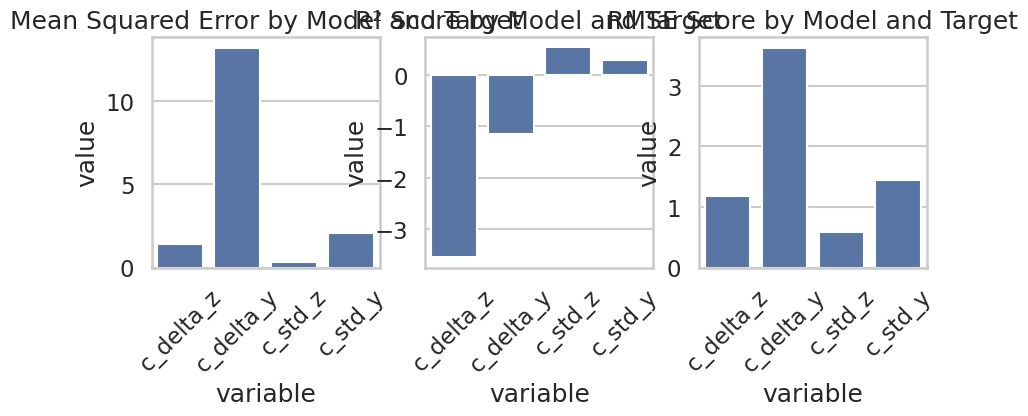

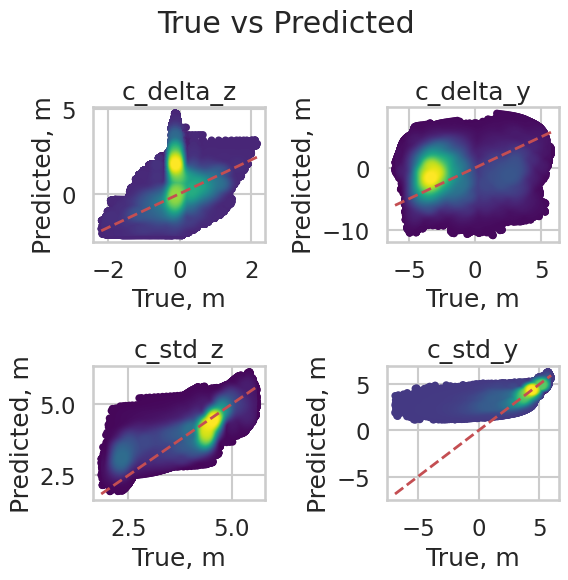

                 mse        r2      rmse
c_delta_z   1.384209 -3.533553  1.176524
c_delta_y  13.197480 -1.145590  3.632834
c_std_z     0.343945  0.536513  0.586468
c_std_y     2.067196  0.294196  1.437775


In [47]:
# t_preproc.inverse_transform(y_pred)
y_test_1 = y_test.copy()
t_preproc.transform(y_test_1)
performance_visualizations(y_pred, y_test_1)

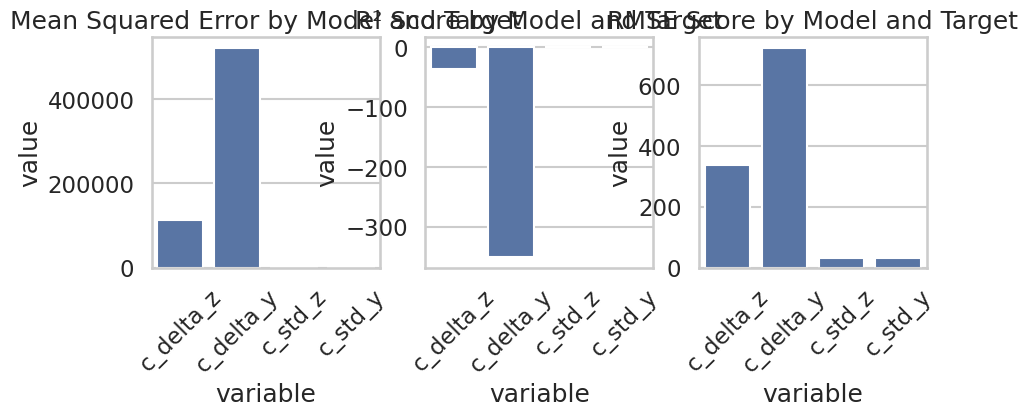

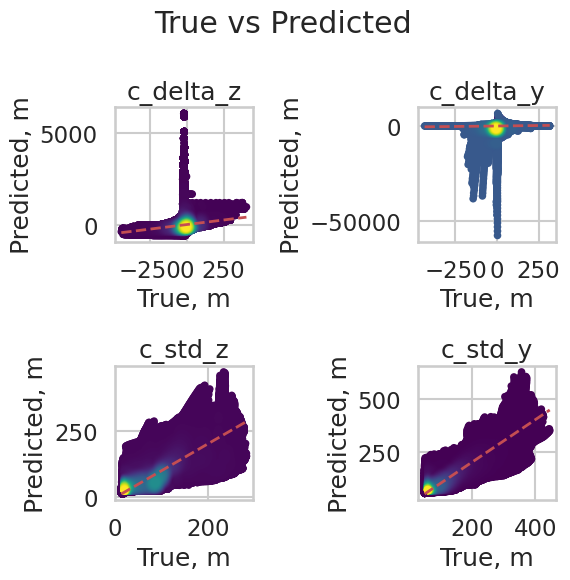

                     mse          r2        rmse
c_delta_z  112690.233965  -35.757111  335.693661
c_delta_y  522640.436299 -350.997807  722.938750
c_std_z      1068.291341    0.520132   32.684726
c_std_y       987.534784    0.703896   31.425066


In [48]:
y_pred = t_preproc.inverse_transform(y_pred)
performance_visualizations(y_pred, y_test)

## Linear Feature Importance

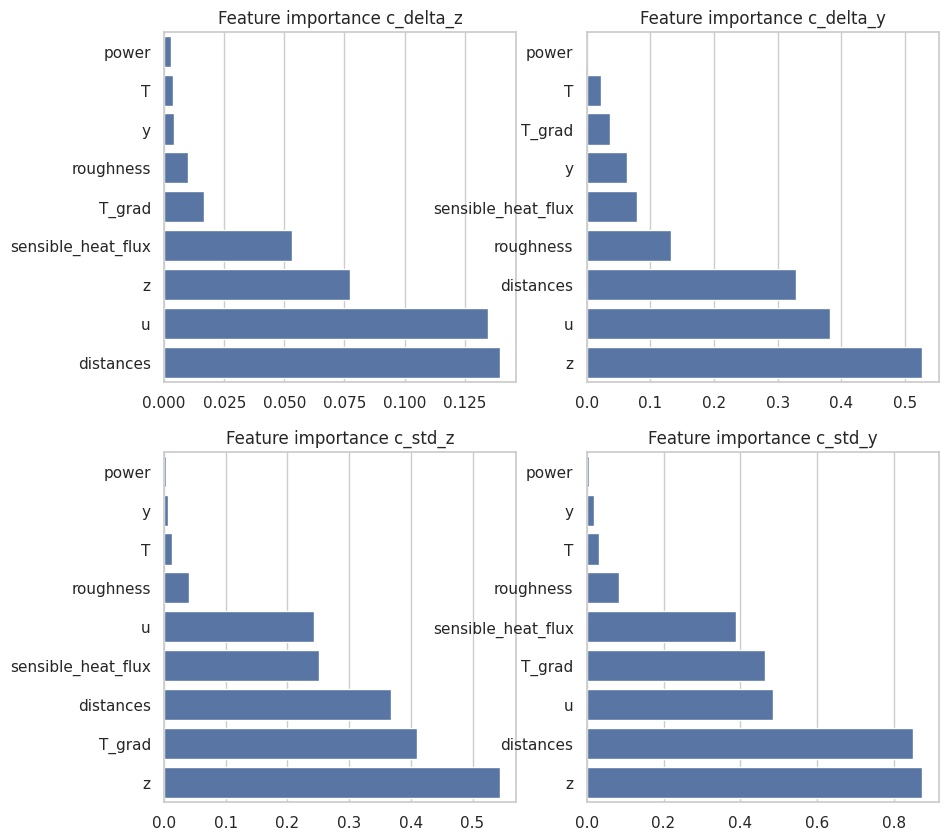

In [38]:
shape_col_t = 2        
shape_row_t = 2
fig, axes = plt.subplots(shape_row_t, shape_col_t, figsize=(10, 10)) 
sns.set_theme(style="whitegrid")
for idx, col in enumerate(y_train.columns):
    row = idx // shape_col_t
    col_idx = idx % shape_row_t
    feature_importance = np.abs(model_l_dict[col].coef_)
    sorted_idx = np.argsort(feature_importance)
    sns.barplot(x = feature_importance[sorted_idx], y=np.array(X_test.columns)[sorted_idx], ax=axes[row, col_idx])
    # axes[row, col_idx].set_yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    axes[row, col_idx].set_title(f'Feature importance {col}')

## Uncertainty of RF models

In [36]:
class UncertaintyRFEstimator:
    def __init__(self, target_transformer, target_name, n_bootstrap=100, alpha=0.05, random_state=42):
        self.n_bootstrap = n_bootstrap
        self.alpha = alpha
        self.random_state = random_state
        self.models = []
        self.base_model = None
        self.target_transformer = target_transformer
        self.target_name = target_name
        self.base_model = RandomForestRegressor(n_estimators=100, n_jobs=64, random_state=random_state)

    def fit(self, X, y):
        y = np.array(y)
        self.base_model.fit(X, y)
        
        # Bootstrap sampling for uncertainty estimation
        n_samples = X.shape[0]
        self.models = []
        
        for i in tqdm(range(self.n_bootstrap), desc="Fitting bootstrap models"):
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            
            # Create and fit a new model
            model = RandomForestRegressor(n_estimators=100, n_jobs=64, random_state=self.random_state+i)
            model.fit(X_bootstrap, y_bootstrap)
            self.models.append(model)
        
        return self
    
    def predict_with_uncertainty(self, X):
        result = {}
        
        # Base model prediction
        y_pred_tmp = self.base_model.predict(X)
        y_pred_tmp = pd.DataFrame(data=y_pred_tmp, columns=[self.target_name])
        self.target_transformer.inverse_transform(y_pred_tmp)
        result['prediction'] = np.array(y_pred_tmp[self.target_name])

        # Bootstrap-based uncertainty
        bootstrap_predictions = []
        for model in tqdm(self.models, desc="Generating bootstrap predictions"):
            
            y_pred_tmp = model.predict(X)
            y_pred_tmp = pd.DataFrame(data=y_pred_tmp, columns=[self.target_name])
            self.target_transformer.inverse_transform(y_pred_tmp)
            bootstrap_predictions.append(np.array(y_pred_tmp[self.target_name]))
        
        bootstrap_predictions = np.array(bootstrap_predictions)
        
        result['mean'] = np.mean(bootstrap_predictions, axis=0)
        result['std'] = np.std(bootstrap_predictions, axis=0)
        lower_percentile = 100 * self.alpha / 2
        upper_percentile = 100 * (1 - self.alpha / 2)
        result['lower_bound'] = np.percentile(bootstrap_predictions, lower_percentile, axis=0)
        result['upper_bound'] = np.percentile(bootstrap_predictions, upper_percentile, axis=0)
        # tree_predictions = []
        # for tree in self.base_model.estimators_:
        #     tree_predictions.append(tree.predict(X))
        # tree_predictions = np.array(tree_predictions)
        # result['tree_variance'] = np.var(tree_predictions, axis=0)
        
        
        return result
    
    def evaluate_uncertainty(self, X_test, y_test):
        predictions = self.predict_with_uncertainty(X_test)
        eval_results = {}
        y_test = np.array(y_test)
        # Evaluate prediction intervals
        in_interval = np.logical_and(
            y_test >= predictions['lower_bound'],
            y_test <= predictions['upper_bound']
        )
        eval_results['interval_coverage'] = np.mean(in_interval)
        eval_results['expected_coverage'] = 1 - self.alpha
        
        # Calculate RMSE
        eval_results['rmse'] = np.sqrt(mean_squared_error(y_test, predictions['prediction']))
        eval_results['std_mean'] = np.mean(predictions["std"])
        # Calculate uncertainty calibration for regression
        # Sort predictions by uncertainty (std)
        # sorted_indices = np.argsort(predictions['std'])
        # sorted_errors = np.abs(y_test - predictions['prediction'])[sorted_indices]
        
        # # Divide into bins and calculate average error in each bin
        # n_bins = 10
        # bin_size = len(sorted_indices) // n_bins
        # bin_errors = []
        # bin_stds = []
        
        # for i in range(n_bins):
        #     start_idx = i * bin_size
        #     end_idx = (i + 1) * bin_size if i < n_bins - 1 else len(sorted_indices)
        #     bin_errors.append(np.mean(sorted_errors[start_idx:end_idx]))
        #     bin_stds.append(np.mean(predictions['std'][sorted_indices[start_idx:end_idx]]))
        
        # eval_results['bin_errors'] = bin_errors
        # eval_results['bin_stds'] = bin_stds
        
        return eval_results
    
    def visualize_uncertainty(self, X_test, y_test=None, m_eval=None, n_samples=None):
        y_test=np.array(y_test)
        if n_samples is not None and n_samples < X_test.shape[0]:
            indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
            X_test_subset = X_test[indices]
            y_test_subset = y_test[indices] if y_test is not None else None
        else:
            X_test_subset = X_test
            y_test_subset = y_test
        
        predictions = self.predict_with_uncertainty(X_test_subset)
        
        
        # Sort by prediction for clearer visualization
        sort_idx = np.argsort(predictions['prediction'])
        
        plt.figure(figsize=(10, 4))
        plt.errorbar(
            np.arange(len(sort_idx)),
            predictions['prediction'][sort_idx],
            yerr=[
                np.abs(predictions['prediction'][sort_idx] - predictions['lower_bound'][sort_idx]),
                np.abs(predictions['upper_bound'][sort_idx] - predictions['prediction'][sort_idx])
            ],
            fmt='o', alpha=0.6, ecolor='lightgray', capsize=3,
            label = f'Uncertainty: {m_eval["std_mean"]:.4f},\nInterval coverage: {m_eval["interval_coverage"]:.4f} (expected: {m_eval["expected_coverage"]:.4f})'
        )
        
        if y_test_subset is not None:
            plt.scatter(np.arange(len(sort_idx)), y_test_subset[sort_idx], 
                        c='red', marker='x', label='Actual')
        
        plt.xlabel('Sample Index (sorted by prediction)')
        plt.ylabel('Prediction')
        plt.title(f'Predictions with Uncertainty, {self.target_name}')

        if y_test_subset is not None:
            plt.legend()
        plt.tight_layout()
        plt.show()
            

    
    def save(self, filename):
        """Save the model and related objects"""
        joblib.dump(self, filename)
    
    @classmethod
    def load(cls, filename):
        """Load a saved model"""
        return joblib.load(filename)

Running Random Forest Regression uncertainty estimation...


Generating bootstrap predictions: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


Random Forest RMSE: 29.5344
Interval coverage: 0.2382 (expected: 0.9500)


Generating bootstrap predictions: 100%|██████████| 10/10 [00:00<00:00, 42.30it/s]


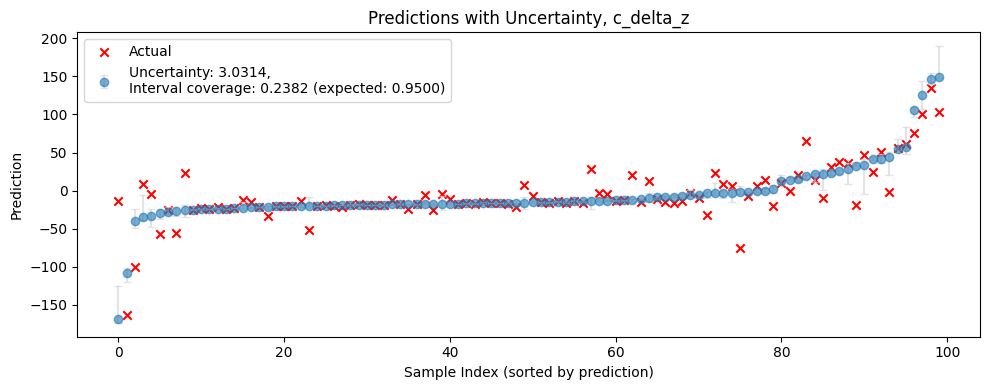

Generating bootstrap predictions: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Random Forest RMSE: 30.5820
Interval coverage: 0.1646 (expected: 0.9500)


Generating bootstrap predictions: 100%|██████████| 10/10 [00:00<00:00, 29.16it/s]


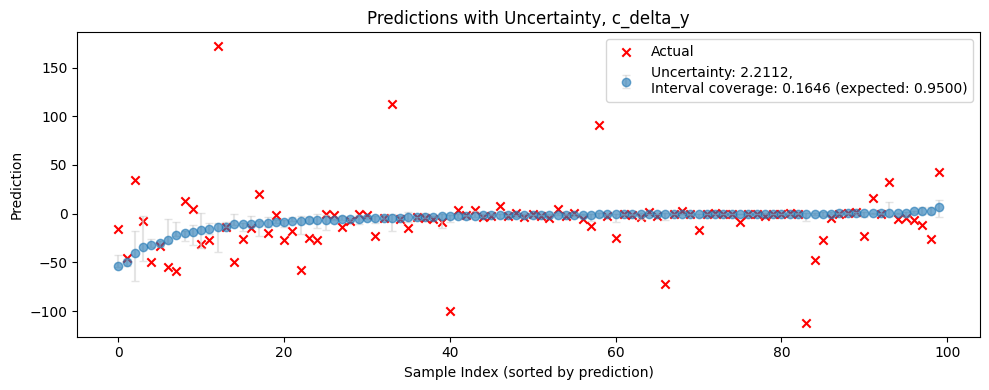

Generating bootstrap predictions: 100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Random Forest RMSE: 14.5959
Interval coverage: 0.2497 (expected: 0.9500)


Generating bootstrap predictions: 100%|██████████| 10/10 [00:00<00:00, 46.87it/s]


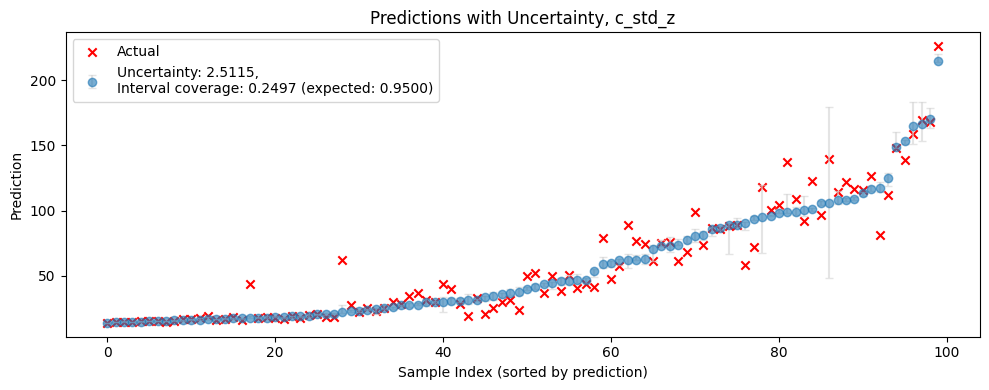

Generating bootstrap predictions: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]


Random Forest RMSE: 21.5395
Interval coverage: 0.2103 (expected: 0.9500)


Generating bootstrap predictions: 100%|██████████| 10/10 [00:00<00:00, 42.30it/s]


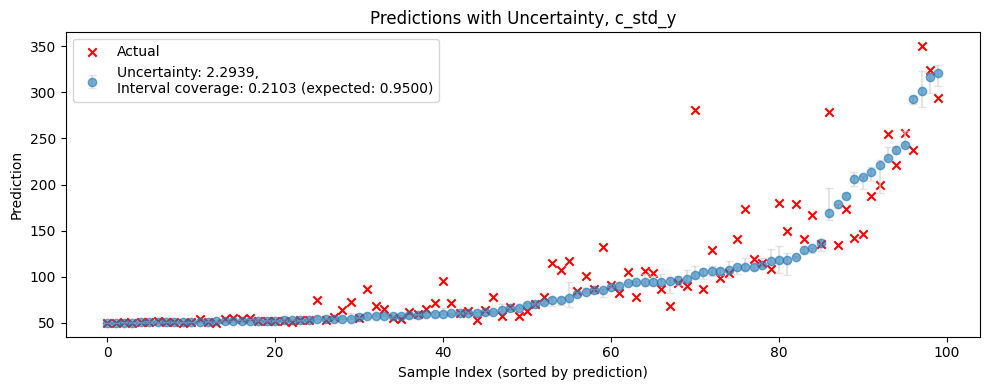

In [37]:
print("Running Random Forest Regression uncertainty estimation...")
for target in y_1.columns:
    rf_uncertainty = UncertaintyRFEstimator(t_preproc,target, n_bootstrap=10)
    rf_uncertainty.fit(X_train_n, y_1[target])
    # rf_predictions = rf_uncertainty.predict_with_uncertainty(X_test_n)
    rf_eval = rf_uncertainty.evaluate_uncertainty(X_test_n, y_test[target])

    print(f"Random Forest RMSE: {rf_eval['rmse']:.4f}")
    print(f"Interval coverage: {rf_eval['interval_coverage']:.4f} (expected: {rf_eval['expected_coverage']:.4f})")

    # Visualize with a subset of samples for clarity
    rf_uncertainty.visualize_uncertainty(X_test_n, y_test[target], rf_eval, n_samples=100)

In [37]:
x = []
for i in range(5):
    x.append(np.arange(3)*10**i)
print(x)

[array([0, 1, 2]), array([ 0, 10, 20]), array([  0, 100, 200]), array([   0, 1000, 2000]), array([    0, 10000, 20000])]


In [41]:
np.percentile(x, 97.5, axis=0)

array([    0.,  9100., 18200.])

## Uncertainty of Linear models

In [38]:
class UncertaintyLinEstimator:
    def __init__(self, target_transformer, target_name, n_bootstrap=100, alpha=0.05, random_state=42):
        self.n_bootstrap = n_bootstrap
        self.alpha = alpha
        self.random_state = random_state
        self.models = []
        self.base_model = None
        self.target_transformer = target_transformer
        self.target_name = target_name
        self.base_model = LinearRegression(n_jobs=64)
    
    def fit(self, X, y):
        
        y = np.array(y)
        # Fit base model
        self.base_model.fit(X, y)
        
        # Bootstrap sampling for uncertainty estimation
        n_samples = X.shape[0]
        self.models = []
        
        for i in tqdm(range(self.n_bootstrap), desc="Fitting bootstrap models"):
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            
            model = LinearRegression(n_jobs=64)
            model.fit(X_bootstrap, y_bootstrap)
            self.models.append(model)
        
        return self
    
    def predict_with_uncertainty(self, X):
        result = {}
        
        # Base model prediction
        y_pred_tmp = self.base_model.predict(X)
        y_pred_tmp = pd.DataFrame(data=y_pred_tmp, columns=[self.target_name])
        self.target_transformer.inverse_transform(y_pred_tmp)
        result['prediction'] = np.array(y_pred_tmp[self.target_name])
        
        # Bootstrap-based uncertainty
        bootstrap_predictions = []
        for model in tqdm(self.models, desc="Generating bootstrap predictions"):
            y_pred_tmp = model.predict(X)
            y_pred_tmp = pd.DataFrame(data=y_pred_tmp, columns=[self.target_name])
            self.target_transformer.inverse_transform(y_pred_tmp)
            bootstrap_predictions.append(np.array(y_pred_tmp[self.target_name]))
        
        bootstrap_predictions = np.array(bootstrap_predictions)
        
        result['mean'] = np.mean(bootstrap_predictions, axis=0)
        result['std'] = np.std(bootstrap_predictions, axis=0)
        
        # Calculate prediction intervals
        lower_percentile = 100 * self.alpha / 2
        upper_percentile = 100 * (1 - self.alpha / 2)
        result['lower_bound'] = np.percentile(bootstrap_predictions, lower_percentile, axis=0)
        result['upper_bound'] = np.percentile(bootstrap_predictions, upper_percentile, axis=0)
        
        # y_pred_base = self.base_model.predict(X)
        # y_pred_base = pd.DataFrame(data=y_pred_base, columns=[self.target_name])
        # self.target_transformer.inverse_transform(y_pred_base)
        
        # residual_std = np.sqrt(np.mean((result['prediction'] - y_pred_base) ** 2))
        
        # # Approximate prediction intervals using residual standard error
        # result['linear_lower_bound'] = result['prediction'] - 1.96 * residual_std
        # result['linear_upper_bound'] = result['prediction'] + 1.96 * residual_std
        
        return result
    
    def evaluate_uncertainty(self, X_test, y_test):
        predictions = self.predict_with_uncertainty(X_test)
        eval_results = {}
        y_test = np.array(y_test)
        in_interval = np.logical_and(
            y_test >= predictions['lower_bound'],
            y_test <= predictions['upper_bound']
        )
        eval_results['interval_coverage'] = np.mean(in_interval)
        eval_results['expected_coverage'] = 1 - self.alpha
        
        # Calculate RMSE
        eval_results['rmse'] = np.sqrt(mean_squared_error(y_test, predictions['prediction']))
        eval_results['std_mean'] = np.mean(predictions["std"])
        # Calculate uncertainty calibration for regression
        # Sort predictions by uncertainty (std)
        sorted_indices = np.argsort(predictions['std'])
        sorted_errors = np.abs(y_test - predictions['prediction'])[sorted_indices]
        
        # Divide into bins and calculate average error in each bin
        n_bins = 10
        bin_size = len(sorted_indices) // n_bins
        bin_errors = []
        bin_stds = []
        
        for i in range(n_bins):
            start_idx = i * bin_size
            end_idx = (i + 1) * bin_size if i < n_bins - 1 else len(sorted_indices)
            bin_errors.append(np.mean(sorted_errors[start_idx:end_idx]))
            bin_stds.append(np.mean(predictions['std'][sorted_indices[start_idx:end_idx]]))
        
        eval_results['bin_errors'] = bin_errors
        eval_results['bin_stds'] = bin_stds

        return eval_results
    
    def visualize_uncertainty(self, X_test, y_test=None, m_eval=None, n_samples=None):
        y_test=np.array(y_test)
        if n_samples is not None and n_samples < X_test.shape[0]:
            indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
            X_test_subset = X_test[indices]
            y_test_subset = y_test[indices] if y_test is not None else None
        else:
            X_test_subset = X_test
            y_test_subset = y_test
        
        predictions = self.predict_with_uncertainty(X_test_subset)
        # Sort by prediction for clearer visualization
        sort_idx = np.argsort(predictions['prediction'])
        
        plt.figure(figsize=(12, 6))
        plt.errorbar(
            np.arange(len(sort_idx)),
            predictions['prediction'][sort_idx],
            yerr=[
                np.abs(predictions['prediction'][sort_idx] - predictions['lower_bound'][sort_idx]),
                np.abs(predictions['upper_bound'][sort_idx] - predictions['prediction'][sort_idx])
            ],
            fmt='o', alpha=0.6, ecolor='lightgray', capsize=3,
            label = f'Uncertainty: {m_eval["std_mean"]:.4f},\nInterval coverage: {m_eval["interval_coverage"]:.4f} (expected: {m_eval["expected_coverage"]:.4f})'
        )
        
        if y_test_subset is not None:
            plt.scatter(np.arange(len(sort_idx)), y_test_subset[sort_idx], 
                        c='red', marker='x', label='Actual')
        
        plt.xlabel('Sample Index (sorted by prediction)')
        plt.ylabel('Prediction')
        plt.title(f'Predictions with Uncertainty, {self.target_name}')
        if y_test_subset is not None:
            plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Uncertainty vs. Error plot (if y_test is provided)
        if y_test_subset is not None:
            plt.figure(figsize=(8, 6))
            errors = np.abs(predictions['prediction'] - y_test_subset)
            plt.scatter(predictions['std'], errors, alpha=0.6)
            plt.xlabel('Prediction Standard Deviation')
            plt.ylabel('Absolute Error')
            plt.title('Uncertainty vs. Error')
            
            # Add trend line
            z = np.polyfit(predictions['std'], errors, 1)
            p = np.poly1d(z)
            plt.plot(np.sort(predictions['std']), p(np.sort(predictions['std'])), 
                    'r--', alpha=0.8)
            
            plt.tight_layout()
            plt.show()
            
            # Calibration plot for regression uncertainty
            eval_results = self.evaluate_uncertainty(X_test, y_test)
            plt.figure(figsize=(8, 6))
            plt.plot(eval_results['bin_stds'], eval_results['bin_errors'], 'o-')
            plt.plot([0, max(eval_results['bin_stds'])], [0, max(eval_results['bin_stds'])], 'r--')
            plt.xlabel('Mean Predicted Standard Deviation')
            plt.ylabel('Mean Absolute Error')
            plt.title('Uncertainty Calibration')
            plt.tight_layout()
            plt.show()
        
    
    def save(self, filename):
        """Save the model and related objects"""
        joblib.dump(self, filename)
    
    @classmethod
    def load(cls, filename):
        """Load a saved model"""
        return joblib.load(filename)


Running Linear Regression uncertainty estimation...


Fitting bootstrap models:   0%|          | 0/50 [00:00<?, ?it/s]

Generating bootstrap predictions: 100%|██████████| 50/50 [00:00<00:00, 81.71it/s]


Random Forest RMSE: 46.1238
Interval coverage: 0.0048 (expected: 0.9500)


Generating bootstrap predictions: 100%|██████████| 50/50 [00:00<00:00, 1676.17it/s]


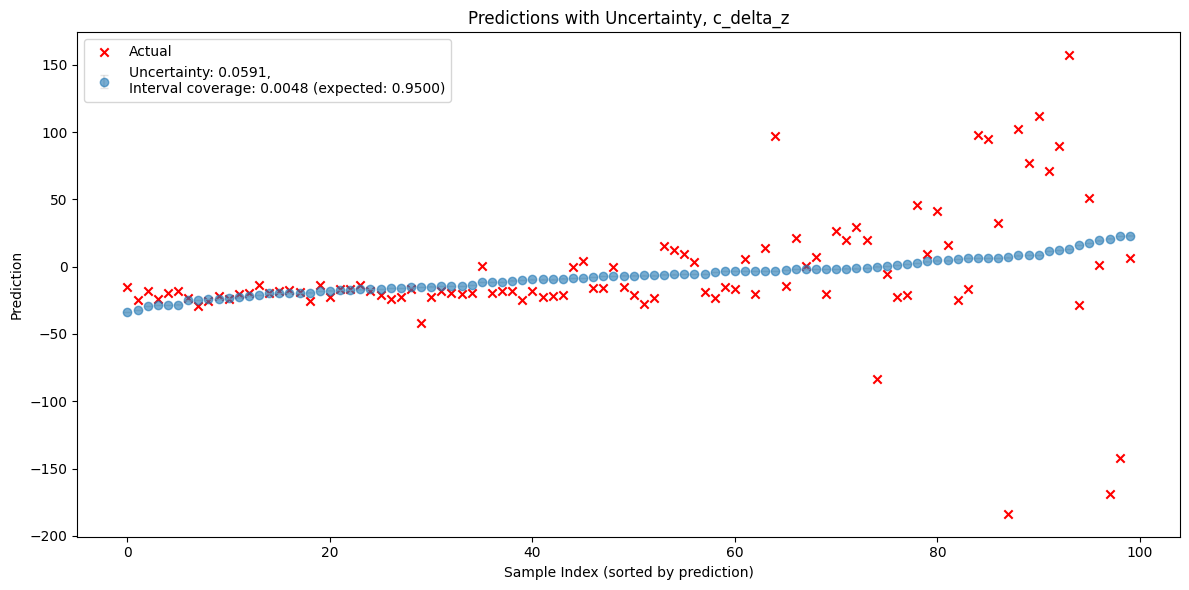

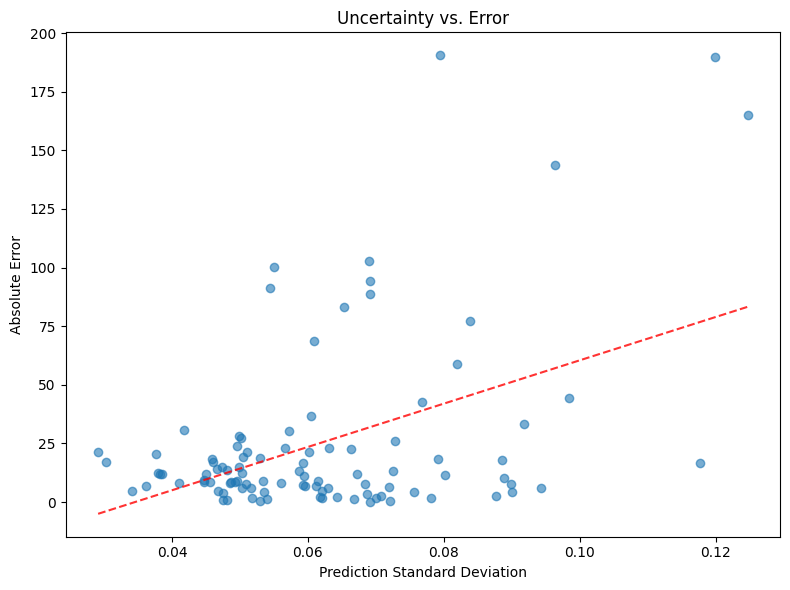

Generating bootstrap predictions: 100%|██████████| 50/50 [00:00<00:00, 77.38it/s]


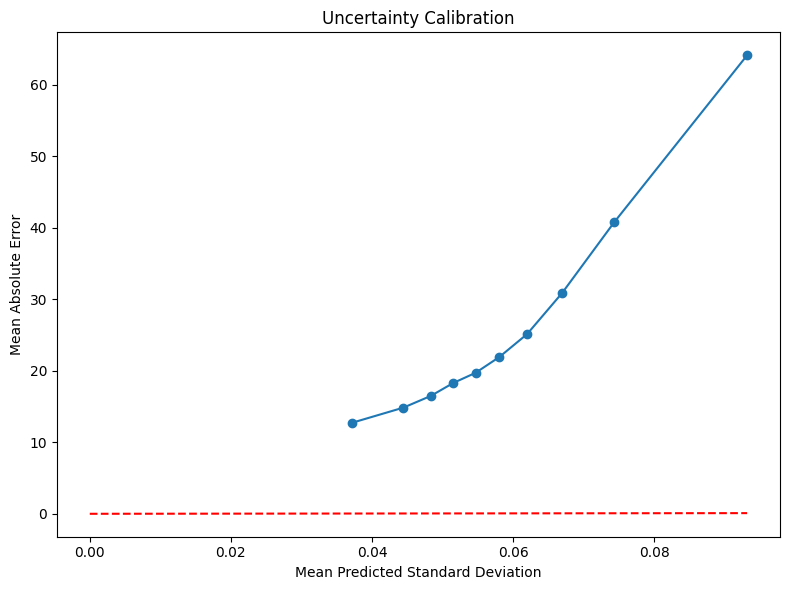

Generating bootstrap predictions: 100%|██████████| 50/50 [00:00<00:00, 60.65it/s]


Random Forest RMSE: 28.9179
Interval coverage: 0.0032 (expected: 0.9500)


Generating bootstrap predictions: 100%|██████████| 50/50 [00:00<00:00, 2151.61it/s]


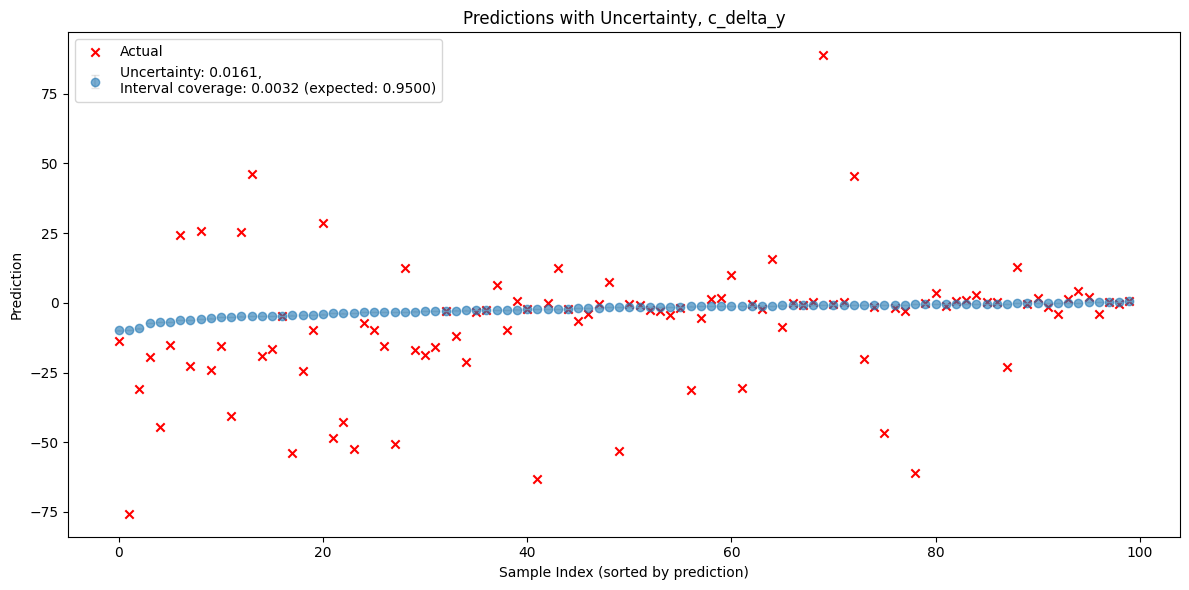

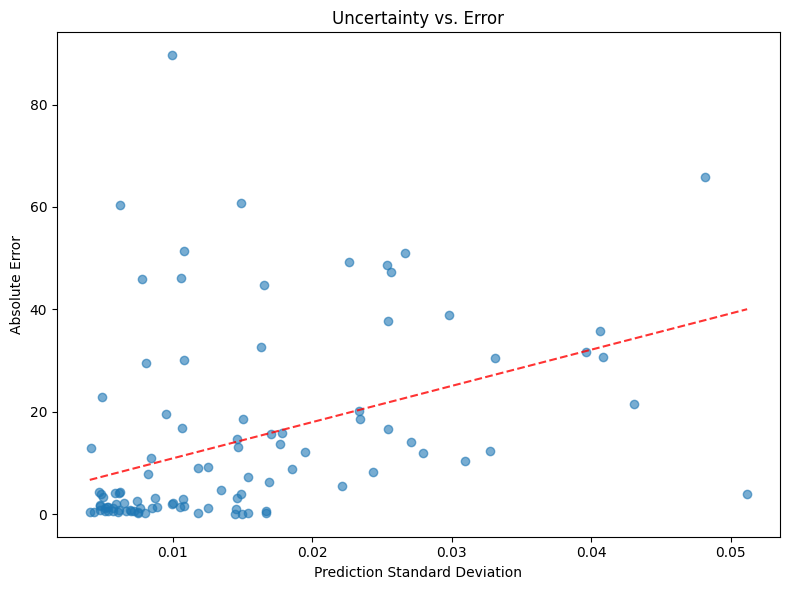

Generating bootstrap predictions: 100%|██████████| 50/50 [00:00<00:00, 66.99it/s]


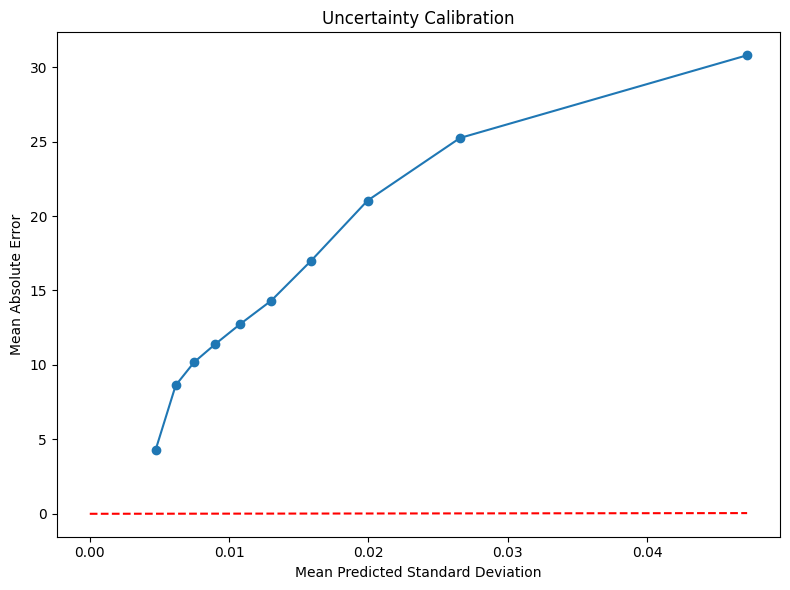

Generating bootstrap predictions: 100%|██████████| 50/50 [00:00<00:00, 68.17it/s]


Random Forest RMSE: 31.6602
Interval coverage: 0.0036 (expected: 0.9500)


Generating bootstrap predictions: 100%|██████████| 50/50 [00:00<00:00, 2756.07it/s]


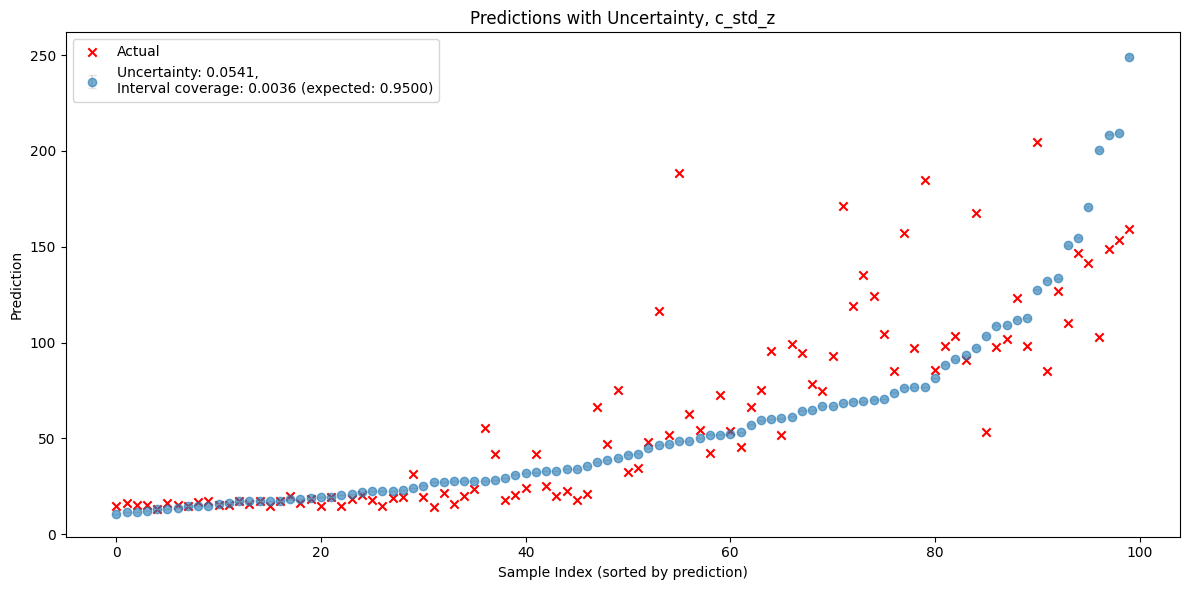

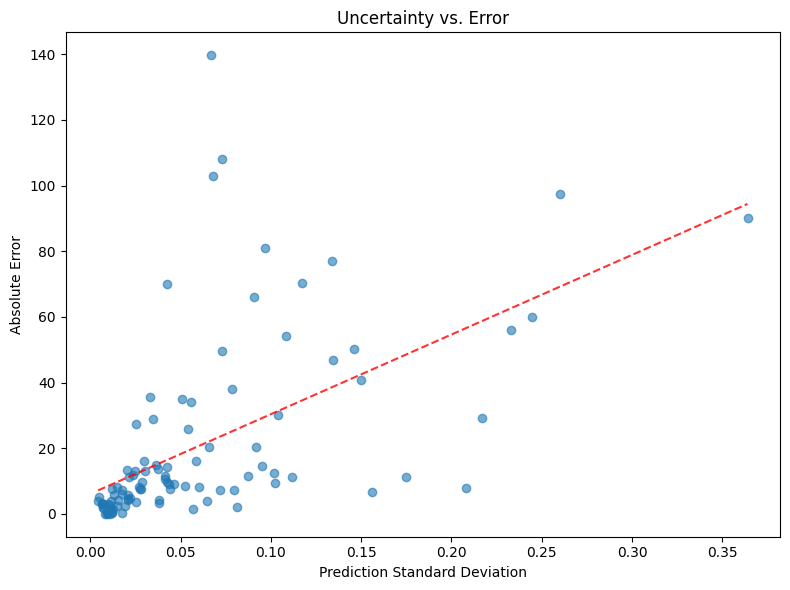

Generating bootstrap predictions: 100%|██████████| 50/50 [00:00<00:00, 66.48it/s]


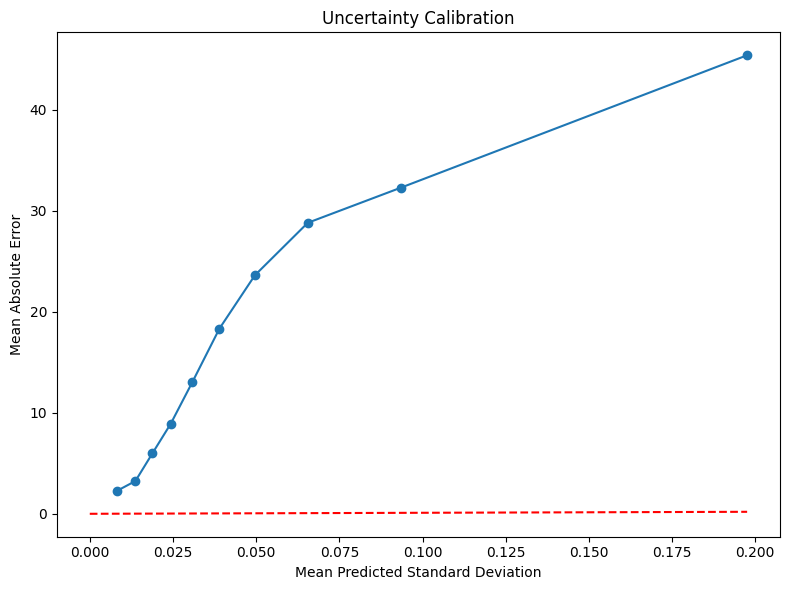

Generating bootstrap predictions: 100%|██████████| 50/50 [00:00<00:00, 90.71it/s]


Random Forest RMSE: 54.0361
Interval coverage: 0.0036 (expected: 0.9500)


Generating bootstrap predictions: 100%|██████████| 50/50 [00:00<00:00, 2820.50it/s]


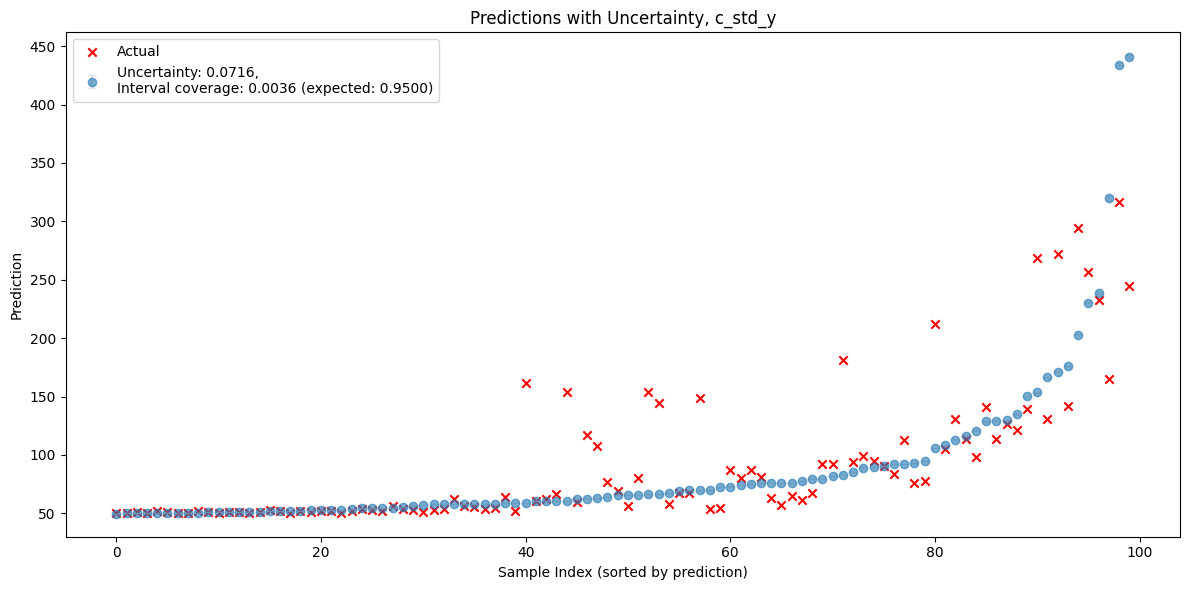

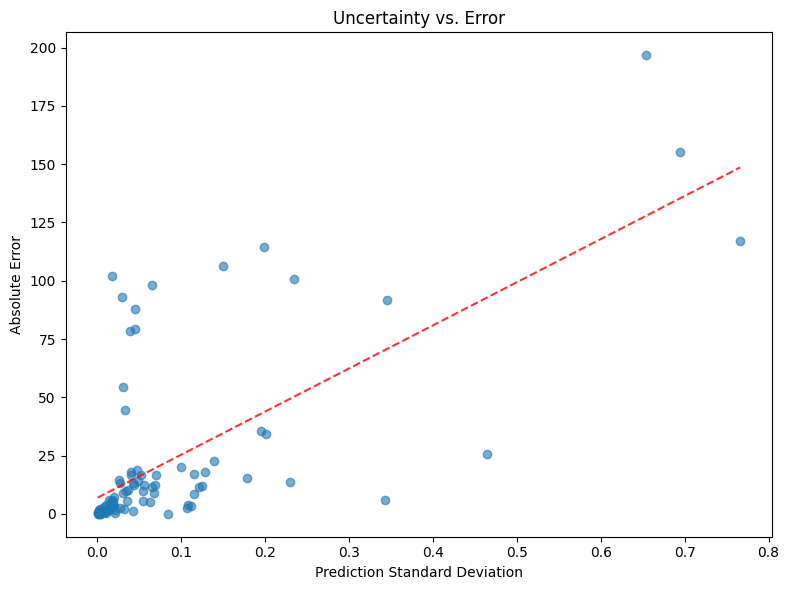

Generating bootstrap predictions: 100%|██████████| 50/50 [00:00<00:00, 96.82it/s] 


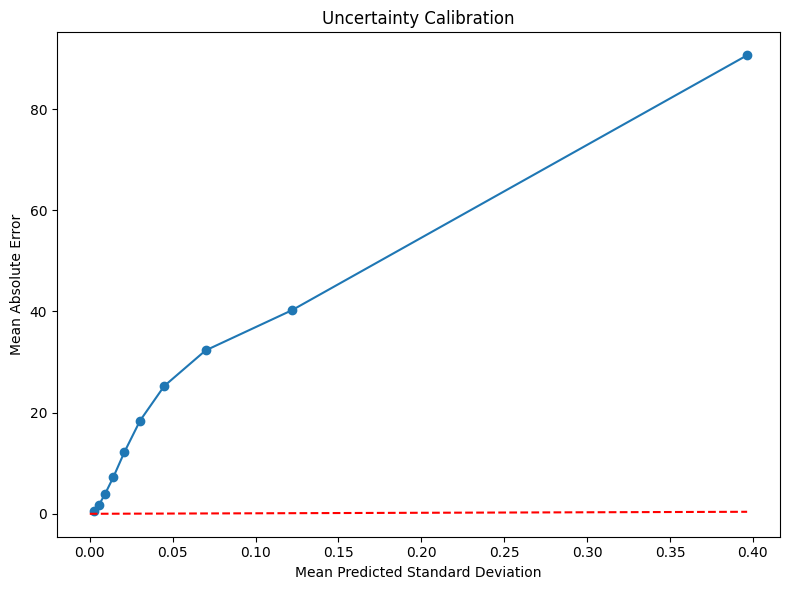

In [39]:
print("\nRunning Linear Regression uncertainty estimation...")

for target in y_1.columns:
    lin_uncertainty = UncertaintyLinEstimator(t_preproc,target, n_bootstrap=50)
    lin_uncertainty.fit(X_train_n, y_1[target])
    # lin_uncertainty = lin_uncertainty.predict_with_uncertainty(X_test_n)
    lin_eval = lin_uncertainty.evaluate_uncertainty(X_test_n, y_test[target])

    print(f"Random Forest RMSE: {lin_eval['rmse']:.4f}")
    print(f"Interval coverage: {lin_eval['interval_coverage']:.4f} (expected: {lin_eval['expected_coverage']:.4f})")

    # Visualize with a subset of samples for clarity
    lin_uncertainty.visualize_uncertainty(X_test_n, y_test[target], lin_eval, n_samples=100)

## Catboost Uncertainty

In [36]:
catboost_model_path = '/app/nse/catboost/' + 'outputs_12_03_2025/' + "models/"

In [94]:
model_c_delta_y = CatBoostRegressor()
model_c_delta_z = CatBoostRegressor()
model_c_std_y = CatBoostRegressor()
model_c_std_z = CatBoostRegressor()

model_c_delta_y.load_model(catboost_model_path + "catboost_c_delta_y.cbm")
model_c_delta_z.load_model(catboost_model_path + "catboost_c_delta_z.cbm")
model_c_std_y.load_model(catboost_model_path + "catboost_c_std_y.cbm")
model_c_std_z.load_model(catboost_model_path + "catboost_c_std_z.cbm")

params = {}
params["c_delta_y"] = model_c_delta_y.get_params()
params["c_delta_z"] = model_c_delta_z.get_params()  
params["c_std_y"] = model_c_std_y.get_params()  
params["c_std_z"] = model_c_std_z.get_params()  

In [ ]:
# print(params_c_std_z)

{'use_best_model': True, 'eval_metric': 'RMSE', 'od_wait': 100, 'verbose': 100, 'iterations': 1000, 'od_type': 'Iter', 'logging_level': 'Silent', 'grow_policy': 'SymmetricTree', 'loss_function': 'RMSE', 'l2_leaf_reg': 2.528883665, 'task_type': 'GPU', 'depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.01996834278, 'random_seed': 42}


In [85]:
class UncertaintyCbEstimator:
    def __init__(self, params, target_transformer, target_name, n_bootstrap=100, alpha=0.05, random_state=42):
        self.n_bootstrap = n_bootstrap
        self.alpha = alpha
        self.random_state = random_state
        self.models = []
        self.base_model = None
        self.params = params
        self.target_transformer = target_transformer
        self.target_name = target_name
        self.base_model = CatBoostRegressor(**self.params)

    def fit(self, X, y, X_eval, y_eval):
        y = np.array(y)
        self.base_model.fit(X, y,
                            eval_set=[(X_eval.copy(), y_eval.copy())])
        
        # Bootstrap sampling for uncertainty estimation
        n_samples = X.shape[0]
        self.models = []
        
        for i in tqdm(range(self.n_bootstrap), desc="Fitting bootstrap models"):
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            
            # Create and fit a new model
            model = CatBoostRegressor(**self.params)
            model.fit(X_bootstrap, y_bootstrap,
                            eval_set=[(X_eval.copy(), y_eval.copy())])
            self.models.append(model)
        
        return self
    
   
    def predict_with_uncertainty(self, X):
        result = {}
        
        # Base model prediction
        y_pred_tmp = self.base_model.predict(X)
        y_pred_tmp = pd.DataFrame(data=y_pred_tmp, columns=[self.target_name])
        self.target_transformer.inverse_transform(y_pred_tmp)
        result['prediction'] = np.array(y_pred_tmp[self.target_name])

        # Bootstrap-based uncertainty
        bootstrap_predictions = []
        for model in tqdm(self.models, desc="Generating bootstrap predictions"):
            
            y_pred_tmp = model.predict(X)
            y_pred_tmp = pd.DataFrame(data=y_pred_tmp, columns=[self.target_name])
            self.target_transformer.inverse_transform(y_pred_tmp)
            bootstrap_predictions.append(np.array(y_pred_tmp[self.target_name]))
        
        bootstrap_predictions = np.array(bootstrap_predictions)
        
        result['mean'] = np.mean(bootstrap_predictions, axis=0)
        result['std'] = np.std(bootstrap_predictions, axis=0)
        lower_percentile = 100 * self.alpha / 2
        upper_percentile = 100 * (1 - self.alpha / 2)
        result['lower_bound'] = np.percentile(bootstrap_predictions, lower_percentile, axis=0)
        result['upper_bound'] = np.percentile(bootstrap_predictions, upper_percentile, axis=0)
        # tree_predictions = []
        # for tree in self.base_model.estimators_:
        #     tree_predictions.append(tree.predict(X))
        # tree_predictions = np.array(tree_predictions)
        # result['tree_variance'] = np.var(tree_predictions, axis=0)
        
        
        return result
    
    def evaluate_uncertainty(self, X_test, y_test):
        predictions = self.predict_with_uncertainty(X_test)
        eval_results = {}
        y_test = np.array(y_test)
        # Evaluate prediction intervals
        in_interval = np.logical_and(
            y_test >= predictions['lower_bound'],
            y_test <= predictions['upper_bound']
        )
        eval_results['interval_coverage'] = np.mean(in_interval)
        eval_results['expected_coverage'] = 1 - self.alpha
        
        # Calculate RMSE
        eval_results['rmse'] = np.sqrt(mean_squared_error(y_test, predictions['prediction']))
        eval_results['std_mean'] = np.mean(predictions["std"])
        # Calculate uncertainty calibration for regression
        # Sort predictions by uncertainty (std)
        # sorted_indices = np.argsort(predictions['std'])
        # sorted_errors = np.abs(y_test - predictions['prediction'])[sorted_indices]
        
        # # Divide into bins and calculate average error in each bin
        # n_bins = 10
        # bin_size = len(sorted_indices) // n_bins
        # bin_errors = []
        # bin_stds = []
        
        # for i in range(n_bins):
        #     start_idx = i * bin_size
        #     end_idx = (i + 1) * bin_size if i < n_bins - 1 else len(sorted_indices)
        #     bin_errors.append(np.mean(sorted_errors[start_idx:end_idx]))
        #     bin_stds.append(np.mean(predictions['std'][sorted_indices[start_idx:end_idx]]))
        
        # eval_results['bin_errors'] = bin_errors
        # eval_results['bin_stds'] = bin_stds
        
        return eval_results
    
    def visualize_uncertainty(self, X_test, y_test=None, m_eval=None, n_samples=None):
        y_test=np.array(y_test)
        if n_samples is not None and n_samples < X_test.shape[0]:
            indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
            X_test_subset = X_test[indices]
            y_test_subset = y_test[indices] if y_test is not None else None
        else:
            X_test_subset = X_test
            y_test_subset = y_test
        
        predictions = self.predict_with_uncertainty(X_test_subset)
        
        
        # Sort by prediction for clearer visualization
        sort_idx = np.argsort(predictions['prediction'])
        
        plt.figure(figsize=(10, 4))
        plt.errorbar(
            np.arange(len(sort_idx)),
            predictions['prediction'][sort_idx],
            yerr=[
                np.abs(predictions['prediction'][sort_idx] - predictions['lower_bound'][sort_idx]),
                np.abs(predictions['upper_bound'][sort_idx] - predictions['prediction'][sort_idx])
            ],
            fmt='o', alpha=0.6, ecolor='lightgray', capsize=3,
            label = f'Uncertainty: {m_eval["std_mean"]:.4f},\nInterval coverage: {m_eval["interval_coverage"]:.4f} (expected: {m_eval["expected_coverage"]:.4f})'
        )
        
        if y_test_subset is not None:
            plt.scatter(np.arange(len(sort_idx)), y_test_subset[sort_idx], 
                        c='red', marker='x', label='Actual')
        
        plt.xlabel('Sample Index (sorted by prediction)')
        plt.ylabel('Prediction')
        plt.title(f'Predictions with Uncertainty, {self.target_name}')

        if y_test_subset is not None:
            plt.legend()
        plt.tight_layout()
        plt.show()
            

    
    def save(self, filename):
        """Save the model and related objects"""
        joblib.dump(self, filename)
    
    @classmethod
    def load(cls, filename):
        """Load a saved model"""
        return joblib.load(filename)

Running CatBoost Regression uncertainty estimation...
0:	learn: 0.5324933	test: 0.4871066	best: 0.4871066 (0)	total: 18.2ms	remaining: 18.1s
100:	learn: 0.2725928	test: 0.3290586	best: 0.3290586 (100)	total: 1.71s	remaining: 15.3s
200:	learn: 0.2030845	test: 0.3157410	best: 0.3157410 (200)	total: 3.44s	remaining: 13.7s
300:	learn: 0.1719675	test: 0.3156581	best: 0.3151079 (281)	total: 5.19s	remaining: 12.1s
400:	learn: 0.1524599	test: 0.3128044	best: 0.3128044 (400)	total: 6.95s	remaining: 10.4s
500:	learn: 0.1384269	test: 0.3117738	best: 0.3117738 (500)	total: 8.72s	remaining: 8.68s
600:	learn: 0.1283530	test: 0.3110365	best: 0.3110365 (600)	total: 10.5s	remaining: 6.97s
700:	learn: 0.1206827	test: 0.3109767	best: 0.3108187 (667)	total: 12.3s	remaining: 5.24s
bestTest = 0.3108187281
bestIteration = 667
Shrink model to first 668 iterations.


Fitting bootstrap models:   0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 0.5326716	test: 0.4871478	best: 0.4871478 (0)	total: 18.8ms	remaining: 18.8s
100:	learn: 0.2725034	test: 0.3322363	best: 0.3322363 (100)	total: 1.75s	remaining: 15.6s
200:	learn: 0.2036679	test: 0.3191442	best: 0.3191432 (196)	total: 3.53s	remaining: 14s
300:	learn: 0.1717481	test: 0.3156948	best: 0.3156215 (298)	total: 5.33s	remaining: 12.4s
400:	learn: 0.1524143	test: 0.3128877	best: 0.3128877 (400)	total: 7.14s	remaining: 10.7s
500:	learn: 0.1400319	test: 0.3123078	best: 0.3123078 (500)	total: 8.96s	remaining: 8.93s
600:	learn: 0.1296514	test: 0.3110923	best: 0.3110402 (598)	total: 10.8s	remaining: 7.16s
bestTest = 0.3110401898
bestIteration = 598
Shrink model to first 599 iterations.


Fitting bootstrap models:  10%|█         | 1/10 [00:17<02:33, 17.05s/it]

0:	learn: 0.5325953	test: 0.4867024	best: 0.4867024 (0)	total: 18.9ms	remaining: 18.9s
100:	learn: 0.2732584	test: 0.3281765	best: 0.3281765 (100)	total: 1.75s	remaining: 15.6s
200:	learn: 0.2041921	test: 0.3145622	best: 0.3145622 (200)	total: 3.52s	remaining: 14s
300:	learn: 0.1724772	test: 0.3118096	best: 0.3117206 (298)	total: 5.33s	remaining: 12.4s
400:	learn: 0.1532122	test: 0.3106815	best: 0.3106815 (400)	total: 7.13s	remaining: 10.7s
500:	learn: 0.1391183	test: 0.3096297	best: 0.3096297 (500)	total: 8.94s	remaining: 8.91s
600:	learn: 0.1287053	test: 0.3091091	best: 0.3090455 (597)	total: 10.8s	remaining: 7.15s
700:	learn: 0.1205701	test: 0.3089139	best: 0.3088770 (670)	total: 12.6s	remaining: 5.37s
800:	learn: 0.1140079	test: 0.3088443	best: 0.3088040 (794)	total: 14.4s	remaining: 3.58s
900:	learn: 0.1080196	test: 0.3086770	best: 0.3086770 (900)	total: 16.3s	remaining: 1.79s
999:	learn: 0.1028969	test: 0.3086467	best: 0.3085910 (919)	total: 18.1s	remaining: 0us
bestTest = 0.3085

Fitting bootstrap models:  20%|██        | 2/10 [00:39<02:43, 20.43s/it]

0:	learn: 0.5326146	test: 0.4865166	best: 0.4865166 (0)	total: 19.4ms	remaining: 19.3s
100:	learn: 0.2729471	test: 0.3314977	best: 0.3314977 (100)	total: 1.76s	remaining: 15.7s
200:	learn: 0.2032863	test: 0.3161372	best: 0.3161372 (200)	total: 3.53s	remaining: 14s
300:	learn: 0.1719835	test: 0.3143111	best: 0.3140122 (241)	total: 5.34s	remaining: 12.4s
400:	learn: 0.1521441	test: 0.3137174	best: 0.3134069 (388)	total: 7.14s	remaining: 10.7s
500:	learn: 0.1375464	test: 0.3126180	best: 0.3125987 (497)	total: 8.95s	remaining: 8.92s
600:	learn: 0.1273741	test: 0.3125346	best: 0.3122425 (521)	total: 10.8s	remaining: 7.16s
bestTest = 0.3122424547
bestIteration = 521
Shrink model to first 522 iterations.


Fitting bootstrap models:  30%|███       | 3/10 [00:55<02:07, 18.23s/it]

0:	learn: 0.5324375	test: 0.4869139	best: 0.4869139 (0)	total: 19ms	remaining: 19s
100:	learn: 0.2730416	test: 0.3281764	best: 0.3281764 (100)	total: 1.76s	remaining: 15.7s
200:	learn: 0.2035582	test: 0.3135967	best: 0.3134721 (196)	total: 3.53s	remaining: 14s
300:	learn: 0.1726268	test: 0.3093765	best: 0.3093515 (298)	total: 5.34s	remaining: 12.4s
400:	learn: 0.1528347	test: 0.3070722	best: 0.3069168 (395)	total: 7.15s	remaining: 10.7s
500:	learn: 0.1392843	test: 0.3058896	best: 0.3058896 (500)	total: 8.96s	remaining: 8.93s
600:	learn: 0.1293828	test: 0.3057366	best: 0.3057366 (600)	total: 10.8s	remaining: 7.16s
700:	learn: 0.1211438	test: 0.3055482	best: 0.3054715 (688)	total: 12.6s	remaining: 5.38s
800:	learn: 0.1146798	test: 0.3051955	best: 0.3051453 (793)	total: 14.4s	remaining: 3.59s
900:	learn: 0.1086358	test: 0.3050690	best: 0.3050527 (897)	total: 16.3s	remaining: 1.79s
999:	learn: 0.1035021	test: 0.3049972	best: 0.3049360 (977)	total: 18.1s	remaining: 0us
bestTest = 0.30493603

Fitting bootstrap models:  40%|████      | 4/10 [01:18<02:00, 20.00s/it]

0:	learn: 0.5324034	test: 0.4864827	best: 0.4864827 (0)	total: 18.7ms	remaining: 18.7s
100:	learn: 0.2732421	test: 0.3333230	best: 0.3333230 (100)	total: 1.76s	remaining: 15.6s
200:	learn: 0.2033625	test: 0.3238052	best: 0.3233126 (188)	total: 3.53s	remaining: 14s
300:	learn: 0.1734165	test: 0.3209954	best: 0.3208958 (294)	total: 5.33s	remaining: 12.4s
400:	learn: 0.1539997	test: 0.3193804	best: 0.3193726 (393)	total: 7.14s	remaining: 10.7s
500:	learn: 0.1394774	test: 0.3178392	best: 0.3178237 (499)	total: 8.96s	remaining: 8.92s
600:	learn: 0.1283522	test: 0.3174500	best: 0.3174069 (591)	total: 10.8s	remaining: 7.16s
700:	learn: 0.1205662	test: 0.3172377	best: 0.3172377 (700)	total: 12.6s	remaining: 5.38s
800:	learn: 0.1140099	test: 0.3169069	best: 0.3168207 (788)	total: 14.4s	remaining: 3.59s
900:	learn: 0.1080000	test: 0.3166556	best: 0.3166114 (881)	total: 16.3s	remaining: 1.79s
999:	learn: 0.1026689	test: 0.3165770	best: 0.3165226 (992)	total: 18.1s	remaining: 0us
bestTest = 0.3165

Fitting bootstrap models:  50%|█████     | 5/10 [01:40<01:44, 20.95s/it]

0:	learn: 0.5324882	test: 0.4869545	best: 0.4869545 (0)	total: 18.8ms	remaining: 18.8s
100:	learn: 0.2707501	test: 0.3351044	best: 0.3351044 (100)	total: 1.75s	remaining: 15.6s
200:	learn: 0.2034910	test: 0.3216207	best: 0.3216207 (200)	total: 3.52s	remaining: 14s
300:	learn: 0.1721080	test: 0.3178107	best: 0.3177879 (299)	total: 5.32s	remaining: 12.4s
400:	learn: 0.1526204	test: 0.3161006	best: 0.3159150 (398)	total: 7.13s	remaining: 10.6s
500:	learn: 0.1387224	test: 0.3151685	best: 0.3151685 (500)	total: 8.94s	remaining: 8.9s
600:	learn: 0.1290175	test: 0.3143674	best: 0.3143674 (600)	total: 10.8s	remaining: 7.15s
700:	learn: 0.1210552	test: 0.3139780	best: 0.3139210 (675)	total: 12.6s	remaining: 5.37s
800:	learn: 0.1140984	test: 0.3136602	best: 0.3136602 (800)	total: 14.4s	remaining: 3.58s
900:	learn: 0.1082968	test: 0.3131329	best: 0.3130879 (892)	total: 16.2s	remaining: 1.78s
999:	learn: 0.1031890	test: 0.3132149	best: 0.3130765 (936)	total: 18.1s	remaining: 0us
bestTest = 0.31307

Fitting bootstrap models:  60%|██████    | 6/10 [02:03<01:26, 21.51s/it]

0:	learn: 0.5321587	test: 0.4870170	best: 0.4870170 (0)	total: 18.9ms	remaining: 18.8s
100:	learn: 0.2727333	test: 0.3305146	best: 0.3305146 (100)	total: 1.76s	remaining: 15.7s
200:	learn: 0.2043001	test: 0.3206483	best: 0.3206483 (200)	total: 3.53s	remaining: 14s
300:	learn: 0.1730270	test: 0.3170013	best: 0.3167232 (298)	total: 5.33s	remaining: 12.4s
400:	learn: 0.1519838	test: 0.3147544	best: 0.3145107 (394)	total: 7.13s	remaining: 10.7s
500:	learn: 0.1386591	test: 0.3141560	best: 0.3141054 (479)	total: 8.95s	remaining: 8.91s
600:	learn: 0.1287231	test: 0.3139521	best: 0.3138882 (566)	total: 10.8s	remaining: 7.15s
700:	learn: 0.1202351	test: 0.3134961	best: 0.3134574 (698)	total: 12.6s	remaining: 5.38s
800:	learn: 0.1136692	test: 0.3132118	best: 0.3131707 (799)	total: 14.4s	remaining: 3.58s
900:	learn: 0.1078003	test: 0.3133822	best: 0.3131175 (815)	total: 16.3s	remaining: 1.79s
bestTest = 0.3131174924
bestIteration = 815
Shrink model to first 816 iterations.


Fitting bootstrap models:  70%|███████   | 7/10 [02:24<01:03, 21.30s/it]

0:	learn: 0.5328632	test: 0.4872151	best: 0.4872151 (0)	total: 18.8ms	remaining: 18.8s
100:	learn: 0.2737832	test: 0.3282641	best: 0.3282641 (100)	total: 1.76s	remaining: 15.6s
200:	learn: 0.2044661	test: 0.3147514	best: 0.3147514 (200)	total: 3.53s	remaining: 14s
300:	learn: 0.1729791	test: 0.3101690	best: 0.3101690 (300)	total: 5.33s	remaining: 12.4s
400:	learn: 0.1533489	test: 0.3094823	best: 0.3094230 (389)	total: 7.13s	remaining: 10.7s
500:	learn: 0.1384752	test: 0.3087789	best: 0.3087393 (498)	total: 8.95s	remaining: 8.92s
600:	learn: 0.1286540	test: 0.3085909	best: 0.3084656 (593)	total: 10.8s	remaining: 7.16s
700:	learn: 0.1203332	test: 0.3082124	best: 0.3082124 (700)	total: 12.6s	remaining: 5.38s
800:	learn: 0.1134265	test: 0.3077593	best: 0.3077593 (800)	total: 14.4s	remaining: 3.59s
900:	learn: 0.1078318	test: 0.3074774	best: 0.3074403 (888)	total: 16.3s	remaining: 1.79s
bestTest = 0.3074403102
bestIteration = 888
Shrink model to first 889 iterations.


Fitting bootstrap models:  80%|████████  | 8/10 [02:46<00:43, 21.68s/it]

0:	learn: 0.5326154	test: 0.4862844	best: 0.4862844 (0)	total: 18.7ms	remaining: 18.7s
100:	learn: 0.2728311	test: 0.3288675	best: 0.3288675 (100)	total: 1.76s	remaining: 15.7s
200:	learn: 0.2036358	test: 0.3139575	best: 0.3139575 (200)	total: 3.53s	remaining: 14s
300:	learn: 0.1720677	test: 0.3100457	best: 0.3099832 (298)	total: 5.33s	remaining: 12.4s
400:	learn: 0.1527185	test: 0.3083176	best: 0.3076927 (383)	total: 7.14s	remaining: 10.7s
500:	learn: 0.1397095	test: 0.3081680	best: 0.3075065 (485)	total: 8.96s	remaining: 8.92s
bestTest = 0.3075064701
bestIteration = 485
Shrink model to first 486 iterations.


Fitting bootstrap models:  90%|█████████ | 9/10 [03:01<00:19, 19.55s/it]

0:	learn: 0.5325088	test: 0.4863662	best: 0.4863662 (0)	total: 18.9ms	remaining: 18.8s
100:	learn: 0.2738089	test: 0.3265836	best: 0.3265836 (100)	total: 1.76s	remaining: 15.7s
200:	learn: 0.2051416	test: 0.3145579	best: 0.3145579 (200)	total: 3.53s	remaining: 14s
300:	learn: 0.1729696	test: 0.3106007	best: 0.3106007 (300)	total: 5.33s	remaining: 12.4s
400:	learn: 0.1531143	test: 0.3097036	best: 0.3093171 (369)	total: 7.14s	remaining: 10.7s
500:	learn: 0.1380697	test: 0.3078489	best: 0.3078028 (496)	total: 8.96s	remaining: 8.92s
600:	learn: 0.1275174	test: 0.3065593	best: 0.3065593 (600)	total: 10.8s	remaining: 7.16s
700:	learn: 0.1197404	test: 0.3057535	best: 0.3057535 (700)	total: 12.6s	remaining: 5.38s
800:	learn: 0.1133191	test: 0.3057970	best: 0.3057473 (701)	total: 14.4s	remaining: 3.59s
bestTest = 0.3057473362
bestIteration = 701
Shrink model to first 702 iterations.


Generating bootstrap predictions: 100%|██████████| 10/10 [00:00<00:00, 18.42it/s]


Catboost RMSE: 27.2297
Interval coverage: 0.1427 (expected: 0.9500)


Generating bootstrap predictions: 100%|██████████| 10/10 [00:00<00:00, 557.18it/s]


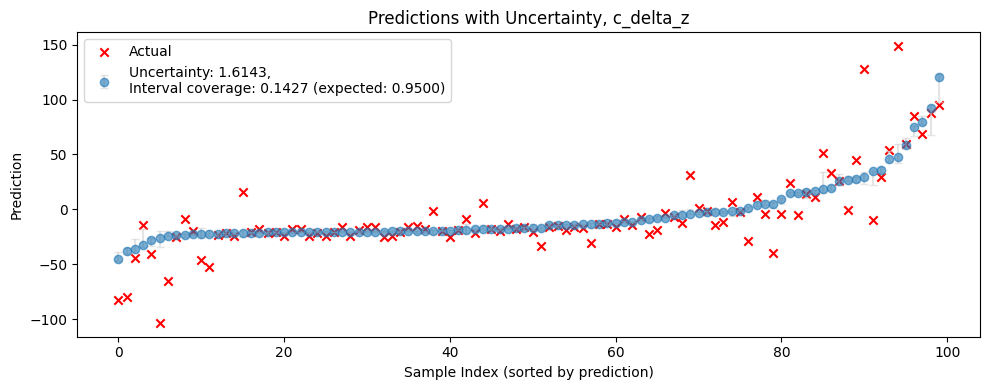

0:	learn: 2.1755807	test: 2.1675587	best: 2.1675587 (0)	total: 6.09ms	remaining: 6.09s
100:	learn: 1.7739985	test: 2.0264939	best: 2.0264939 (100)	total: 559ms	remaining: 4.98s
200:	learn: 1.6553816	test: 2.0118105	best: 2.0106518 (183)	total: 1.13s	remaining: 4.49s
bestTest = 2.010651764
bestIteration = 183
Shrink model to first 184 iterations.


Fitting bootstrap models:   0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 2.1767942	test: 2.1677435	best: 2.1677435 (0)	total: 6.64ms	remaining: 6.64s
100:	learn: 1.7754401	test: 2.0334477	best: 2.0334477 (100)	total: 610ms	remaining: 5.43s
200:	learn: 1.6561665	test: 2.0204860	best: 2.0200645 (159)	total: 1.21s	remaining: 4.83s
300:	learn: 1.5848654	test: 2.0215197	best: 2.0184154 (254)	total: 1.83s	remaining: 4.26s


Fitting bootstrap models:  10%|█         | 1/10 [00:06<00:58,  6.48s/it]

bestTest = 2.018415418
bestIteration = 254
Shrink model to first 255 iterations.
0:	learn: 2.1778710	test: 2.1670626	best: 2.1670626 (0)	total: 6.88ms	remaining: 6.88s
100:	learn: 1.7726765	test: 2.0292585	best: 2.0291633 (99)	total: 609ms	remaining: 5.42s
200:	learn: 1.6540441	test: 2.0197577	best: 2.0166696 (184)	total: 1.21s	remaining: 4.83s


Fitting bootstrap models:  20%|██        | 2/10 [00:12<00:49,  6.20s/it]

bestTest = 2.016669609
bestIteration = 184
Shrink model to first 185 iterations.
0:	learn: 2.1764390	test: 2.1667655	best: 2.1667655 (0)	total: 6.77ms	remaining: 6.76s
100:	learn: 1.7770919	test: 2.0217327	best: 2.0217327 (100)	total: 612ms	remaining: 5.45s
200:	learn: 1.6580476	test: 2.0100168	best: 2.0097754 (177)	total: 1.22s	remaining: 4.84s


Fitting bootstrap models:  30%|███       | 3/10 [00:18<00:43,  6.17s/it]

300:	learn: 1.5888739	test: 2.0157785	best: 2.0097709 (202)	total: 1.84s	remaining: 4.29s
bestTest = 2.009770936
bestIteration = 202
Shrink model to first 203 iterations.
0:	learn: 2.1747532	test: 2.1671017	best: 2.1671017 (0)	total: 6.74ms	remaining: 6.73s
100:	learn: 1.7755384	test: 2.0312517	best: 2.0304938 (94)	total: 604ms	remaining: 5.38s
200:	learn: 1.6592960	test: 2.0198629	best: 2.0182572 (190)	total: 1.2s	remaining: 4.77s
300:	learn: 1.5926454	test: 2.0219826	best: 2.0182332 (239)	total: 1.82s	remaining: 4.24s


Fitting bootstrap models:  40%|████      | 4/10 [00:24<00:37,  6.21s/it]

bestTest = 2.018233166
bestIteration = 239
Shrink model to first 240 iterations.
0:	learn: 2.1739671	test: 2.1666488	best: 2.1666488 (0)	total: 7.06ms	remaining: 7.05s
100:	learn: 1.7732461	test: 2.0332978	best: 2.0331296 (99)	total: 603ms	remaining: 5.37s
200:	learn: 1.6546332	test: 2.0293316	best: 2.0289452 (151)	total: 1.2s	remaining: 4.78s
300:	learn: 1.5879487	test: 2.0309734	best: 2.0284362 (236)	total: 1.83s	remaining: 4.24s


Fitting bootstrap models:  50%|█████     | 5/10 [00:31<00:30,  6.18s/it]

bestTest = 2.028436193
bestIteration = 236
Shrink model to first 237 iterations.
0:	learn: 2.1758118	test: 2.1683492	best: 2.1683492 (0)	total: 6.79ms	remaining: 6.78s
100:	learn: 1.7754745	test: 2.0336410	best: 2.0332075 (97)	total: 609ms	remaining: 5.42s
200:	learn: 1.6587530	test: 2.0256169	best: 2.0224764 (172)	total: 1.22s	remaining: 4.83s


Fitting bootstrap models:  60%|██████    | 6/10 [00:37<00:24,  6.11s/it]

bestTest = 2.02247641
bestIteration = 172
Shrink model to first 173 iterations.
0:	learn: 2.1783754	test: 2.1676516	best: 2.1676516 (0)	total: 6.98ms	remaining: 6.97s
100:	learn: 1.7760887	test: 2.0382909	best: 2.0359093 (96)	total: 608ms	remaining: 5.41s
200:	learn: 1.6572574	test: 2.0306309	best: 2.0270256 (150)	total: 1.2s	remaining: 4.79s


Fitting bootstrap models:  70%|███████   | 7/10 [00:42<00:17,  5.94s/it]

bestTest = 2.027025637
bestIteration = 150
Shrink model to first 151 iterations.
0:	learn: 2.1748277	test: 2.1672383	best: 2.1672383 (0)	total: 6.79ms	remaining: 6.78s
100:	learn: 1.7768236	test: 2.0232054	best: 2.0232054 (100)	total: 610ms	remaining: 5.43s
200:	learn: 1.6614520	test: 2.0101400	best: 2.0095962 (197)	total: 1.22s	remaining: 4.83s


Fitting bootstrap models:  80%|████████  | 8/10 [00:48<00:12,  6.01s/it]

bestTest = 2.009596198
bestIteration = 197
Shrink model to first 198 iterations.
0:	learn: 2.1749640	test: 2.1670006	best: 2.1670006 (0)	total: 6.49ms	remaining: 6.49s
100:	learn: 1.7756781	test: 2.0227722	best: 2.0227722 (100)	total: 598ms	remaining: 5.32s
200:	learn: 1.6579627	test: 2.0135569	best: 2.0076951 (149)	total: 1.2s	remaining: 4.77s


Fitting bootstrap models:  90%|█████████ | 9/10 [00:54<00:05,  5.92s/it]

bestTest = 2.007695102
bestIteration = 149
Shrink model to first 150 iterations.
0:	learn: 2.1763007	test: 2.1674188	best: 2.1674188 (0)	total: 6.74ms	remaining: 6.73s
100:	learn: 1.7755245	test: 2.0169266	best: 2.0169266 (100)	total: 605ms	remaining: 5.38s
200:	learn: 1.6551074	test: 2.0047624	best: 2.0042451 (197)	total: 1.21s	remaining: 4.79s
300:	learn: 1.5864330	test: 2.0116455	best: 2.0038827 (207)	total: 1.84s	remaining: 4.26s
bestTest = 2.003882745
bestIteration = 207
Shrink model to first 208 iterations.


Generating bootstrap predictions: 100%|██████████| 10/10 [00:00<00:00, 39.64it/s]


Catboost RMSE: 28.1398
Interval coverage: 0.0469 (expected: 0.9500)


Generating bootstrap predictions: 100%|██████████| 10/10 [00:00<00:00, 836.74it/s]


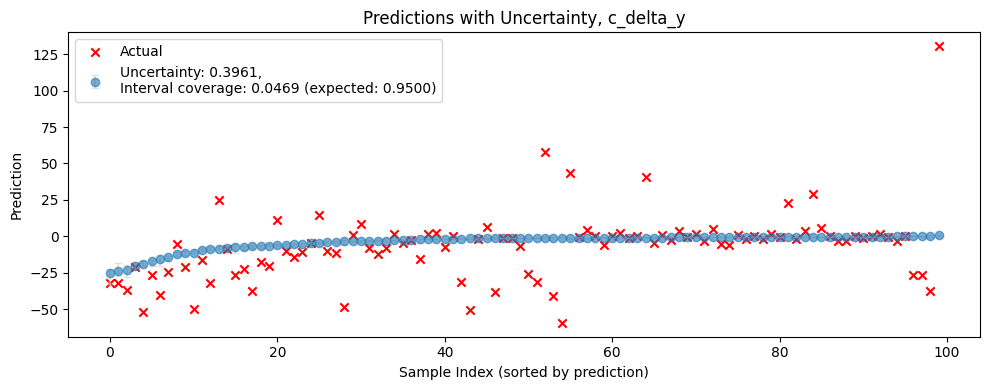

0:	learn: 0.9613730	test: 0.8949195	best: 0.8949195 (0)	total: 7.53ms	remaining: 7.52s
100:	learn: 0.2376661	test: 0.2567873	best: 0.2567873 (100)	total: 717ms	remaining: 6.38s
200:	learn: 0.1528330	test: 0.1960421	best: 0.1960421 (200)	total: 1.46s	remaining: 5.78s
300:	learn: 0.1327257	test: 0.1882901	best: 0.1882853 (299)	total: 2.27s	remaining: 5.27s
400:	learn: 0.1207337	test: 0.1857586	best: 0.1857586 (400)	total: 3.06s	remaining: 4.57s
500:	learn: 0.1127271	test: 0.1849316	best: 0.1848556 (494)	total: 3.85s	remaining: 3.84s
600:	learn: 0.1068450	test: 0.1842987	best: 0.1842987 (600)	total: 4.64s	remaining: 3.08s
700:	learn: 0.1019422	test: 0.1834192	best: 0.1833230 (685)	total: 5.43s	remaining: 2.32s
800:	learn: 0.0977305	test: 0.1828883	best: 0.1828643 (781)	total: 6.22s	remaining: 1.55s
900:	learn: 0.0941557	test: 0.1825933	best: 0.1825303 (894)	total: 7.03s	remaining: 772ms
999:	learn: 0.0908703	test: 0.1823720	best: 0.1823587 (978)	total: 7.82s	remaining: 0us
bestTest = 0.18

Fitting bootstrap models:   0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 0.9612953	test: 0.8944847	best: 0.8944847 (0)	total: 8.22ms	remaining: 8.21s
100:	learn: 0.2370293	test: 0.2641197	best: 0.2641197 (100)	total: 759ms	remaining: 6.75s
200:	learn: 0.1525443	test: 0.2032192	best: 0.2032192 (200)	total: 1.54s	remaining: 6.13s
300:	learn: 0.1325047	test: 0.1943827	best: 0.1943827 (300)	total: 2.38s	remaining: 5.54s
400:	learn: 0.1207552	test: 0.1920030	best: 0.1920030 (400)	total: 3.21s	remaining: 4.8s
500:	learn: 0.1125393	test: 0.1908498	best: 0.1908498 (500)	total: 4.03s	remaining: 4.02s
600:	learn: 0.1064431	test: 0.1901943	best: 0.1901847 (593)	total: 4.85s	remaining: 3.22s
700:	learn: 0.1011688	test: 0.1900321	best: 0.1900050 (683)	total: 5.67s	remaining: 2.42s
800:	learn: 0.0970523	test: 0.1895725	best: 0.1895725 (800)	total: 6.51s	remaining: 1.62s
900:	learn: 0.0936887	test: 0.1890896	best: 0.1890883 (899)	total: 7.41s	remaining: 814ms
999:	learn: 0.0907842	test: 0.1888550	best: 0.1888550 (999)	total: 8.29s	remaining: 0us
bestTest = 0.188

Fitting bootstrap models:  10%|█         | 1/10 [00:32<04:50, 32.30s/it]

0:	learn: 0.9612561	test: 0.8943402	best: 0.8943402 (0)	total: 8.95ms	remaining: 8.94s
100:	learn: 0.2377631	test: 0.2628808	best: 0.2628808 (100)	total: 834ms	remaining: 7.42s
200:	learn: 0.1522277	test: 0.2015550	best: 0.2015550 (200)	total: 1.67s	remaining: 6.64s
300:	learn: 0.1318517	test: 0.1934478	best: 0.1934478 (300)	total: 2.58s	remaining: 5.99s
400:	learn: 0.1201806	test: 0.1909150	best: 0.1909150 (400)	total: 3.44s	remaining: 5.14s
500:	learn: 0.1123912	test: 0.1893506	best: 0.1892646 (496)	total: 4.27s	remaining: 4.25s
600:	learn: 0.1061930	test: 0.1885202	best: 0.1884725 (599)	total: 5.1s	remaining: 3.39s
700:	learn: 0.1013089	test: 0.1879308	best: 0.1879092 (694)	total: 5.94s	remaining: 2.53s
800:	learn: 0.0970519	test: 0.1871922	best: 0.1871922 (800)	total: 6.77s	remaining: 1.68s
900:	learn: 0.0933806	test: 0.1870637	best: 0.1869765 (860)	total: 7.63s	remaining: 838ms
999:	learn: 0.0902937	test: 0.1865692	best: 0.1865598 (997)	total: 8.5s	remaining: 0us
bestTest = 0.1865

Fitting bootstrap models:  20%|██        | 2/10 [01:30<06:21, 47.63s/it]

0:	learn: 0.9616930	test: 0.8946393	best: 0.8946393 (0)	total: 8.65ms	remaining: 8.64s
100:	learn: 0.2383102	test: 0.2558567	best: 0.2558567 (100)	total: 824ms	remaining: 7.34s
200:	learn: 0.1531133	test: 0.1948421	best: 0.1948421 (200)	total: 1.66s	remaining: 6.61s
300:	learn: 0.1329033	test: 0.1865528	best: 0.1864149 (298)	total: 2.57s	remaining: 5.97s
400:	learn: 0.1211697	test: 0.1850994	best: 0.1850994 (400)	total: 3.47s	remaining: 5.19s
500:	learn: 0.1129505	test: 0.1839834	best: 0.1839834 (500)	total: 4.33s	remaining: 4.31s
600:	learn: 0.1067520	test: 0.1831605	best: 0.1831605 (600)	total: 5.15s	remaining: 3.42s
700:	learn: 0.1019668	test: 0.1823188	best: 0.1823066 (699)	total: 5.97s	remaining: 2.54s
800:	learn: 0.0978731	test: 0.1818025	best: 0.1818025 (800)	total: 6.8s	remaining: 1.69s
900:	learn: 0.0942521	test: 0.1815206	best: 0.1815069 (898)	total: 7.63s	remaining: 839ms
999:	learn: 0.0909474	test: 0.1810592	best: 0.1810276 (987)	total: 8.46s	remaining: 0us
bestTest = 0.181

Fitting bootstrap models:  30%|███       | 3/10 [02:23<05:49, 49.88s/it]

0:	learn: 0.9606240	test: 0.8942273	best: 0.8942273 (0)	total: 8.5ms	remaining: 8.49s
100:	learn: 0.2379577	test: 0.2619839	best: 0.2619839 (100)	total: 767ms	remaining: 6.83s
200:	learn: 0.1525569	test: 0.2004089	best: 0.2004089 (200)	total: 1.54s	remaining: 6.13s
300:	learn: 0.1322743	test: 0.1921686	best: 0.1921686 (300)	total: 2.38s	remaining: 5.54s
400:	learn: 0.1200731	test: 0.1898455	best: 0.1898455 (400)	total: 3.22s	remaining: 4.8s
500:	learn: 0.1120410	test: 0.1881367	best: 0.1881367 (500)	total: 4.03s	remaining: 4.01s
600:	learn: 0.1061325	test: 0.1868980	best: 0.1868980 (600)	total: 4.86s	remaining: 3.22s
700:	learn: 0.1014516	test: 0.1863729	best: 0.1862807 (689)	total: 5.67s	remaining: 2.42s
800:	learn: 0.0971847	test: 0.1857618	best: 0.1857146 (797)	total: 6.49s	remaining: 1.61s
900:	learn: 0.0936419	test: 0.1852382	best: 0.1852382 (900)	total: 7.31s	remaining: 803ms
999:	learn: 0.0903593	test: 0.1848918	best: 0.1848778 (998)	total: 8.12s	remaining: 0us
bestTest = 0.1848

Fitting bootstrap models:  40%|████      | 4/10 [02:35<03:30, 35.14s/it]

0:	learn: 0.9610477	test: 0.8940191	best: 0.8940191 (0)	total: 8.39ms	remaining: 8.38s
100:	learn: 0.2382203	test: 0.2575117	best: 0.2575117 (100)	total: 772ms	remaining: 6.87s
200:	learn: 0.1528315	test: 0.1971228	best: 0.1971228 (200)	total: 1.54s	remaining: 6.14s
300:	learn: 0.1327671	test: 0.1888088	best: 0.1888088 (300)	total: 2.38s	remaining: 5.53s
400:	learn: 0.1213114	test: 0.1865392	best: 0.1865392 (400)	total: 3.21s	remaining: 4.79s
500:	learn: 0.1133307	test: 0.1855483	best: 0.1855483 (500)	total: 4.03s	remaining: 4.01s
600:	learn: 0.1070207	test: 0.1847533	best: 0.1847428 (599)	total: 4.85s	remaining: 3.22s
700:	learn: 0.1020424	test: 0.1838949	best: 0.1838949 (700)	total: 5.65s	remaining: 2.41s
800:	learn: 0.0979764	test: 0.1833611	best: 0.1833482 (799)	total: 6.46s	remaining: 1.6s
900:	learn: 0.0942605	test: 0.1830066	best: 0.1829977 (899)	total: 7.27s	remaining: 799ms


Fitting bootstrap models:  50%|█████     | 5/10 [02:48<02:14, 26.99s/it]

999:	learn: 0.0910332	test: 0.1827235	best: 0.1827235 (999)	total: 8.07s	remaining: 0us
bestTest = 0.182723467
bestIteration = 999
0:	learn: 0.9608314	test: 0.8941722	best: 0.8941722 (0)	total: 8.42ms	remaining: 8.41s
100:	learn: 0.2374603	test: 0.2572568	best: 0.2572568 (100)	total: 770ms	remaining: 6.85s
200:	learn: 0.1521730	test: 0.1968088	best: 0.1968088 (200)	total: 1.54s	remaining: 6.11s
300:	learn: 0.1328546	test: 0.1881865	best: 0.1881865 (300)	total: 2.38s	remaining: 5.53s
400:	learn: 0.1208641	test: 0.1866197	best: 0.1866197 (400)	total: 3.21s	remaining: 4.79s
500:	learn: 0.1127317	test: 0.1856014	best: 0.1854469 (494)	total: 4.03s	remaining: 4.01s
600:	learn: 0.1061991	test: 0.1845704	best: 0.1845550 (599)	total: 4.84s	remaining: 3.21s
700:	learn: 0.1011522	test: 0.1842035	best: 0.1841945 (680)	total: 5.67s	remaining: 2.42s
800:	learn: 0.0969926	test: 0.1836835	best: 0.1836835 (800)	total: 6.5s	remaining: 1.61s
900:	learn: 0.0934364	test: 0.1834516	best: 0.1834516 (900)	tot

Fitting bootstrap models:  60%|██████    | 6/10 [03:00<01:28, 22.08s/it]

0:	learn: 0.9610349	test: 0.8942065	best: 0.8942065 (0)	total: 8.44ms	remaining: 8.43s
100:	learn: 0.2387553	test: 0.2653604	best: 0.2653604 (100)	total: 765ms	remaining: 6.81s
200:	learn: 0.1529214	test: 0.2036287	best: 0.2036287 (200)	total: 1.54s	remaining: 6.12s
300:	learn: 0.1331836	test: 0.1943456	best: 0.1943422 (299)	total: 2.38s	remaining: 5.53s
400:	learn: 0.1214962	test: 0.1916627	best: 0.1916466 (395)	total: 3.21s	remaining: 4.8s
500:	learn: 0.1130390	test: 0.1905727	best: 0.1905727 (500)	total: 4.02s	remaining: 4.01s
600:	learn: 0.1070112	test: 0.1898811	best: 0.1897929 (594)	total: 4.84s	remaining: 3.21s
700:	learn: 0.1019159	test: 0.1895642	best: 0.1894911 (678)	total: 5.66s	remaining: 2.41s
800:	learn: 0.0978261	test: 0.1891392	best: 0.1891146 (796)	total: 6.48s	remaining: 1.61s
900:	learn: 0.0940318	test: 0.1886238	best: 0.1886238 (900)	total: 7.29s	remaining: 801ms
999:	learn: 0.0907408	test: 0.1882613	best: 0.1882230 (988)	total: 8.1s	remaining: 0us
bestTest = 0.1882

Fitting bootstrap models:  70%|███████   | 7/10 [03:13<00:56, 18.94s/it]

0:	learn: 0.9615638	test: 0.8942616	best: 0.8942616 (0)	total: 8.47ms	remaining: 8.46s
100:	learn: 0.2384020	test: 0.2618607	best: 0.2618607 (100)	total: 770ms	remaining: 6.86s
200:	learn: 0.1522282	test: 0.2025714	best: 0.2025714 (200)	total: 1.54s	remaining: 6.13s
300:	learn: 0.1326090	test: 0.1942412	best: 0.1942412 (300)	total: 2.38s	remaining: 5.53s
400:	learn: 0.1204233	test: 0.1916568	best: 0.1914879 (392)	total: 3.2s	remaining: 4.79s
500:	learn: 0.1122297	test: 0.1905601	best: 0.1905601 (500)	total: 4.01s	remaining: 4s
600:	learn: 0.1060308	test: 0.1897716	best: 0.1897017 (597)	total: 4.82s	remaining: 3.2s
700:	learn: 0.1011619	test: 0.1891990	best: 0.1891990 (700)	total: 5.62s	remaining: 2.4s
800:	learn: 0.0971687	test: 0.1887023	best: 0.1886934 (797)	total: 6.45s	remaining: 1.6s
900:	learn: 0.0935553	test: 0.1884182	best: 0.1884182 (900)	total: 7.27s	remaining: 798ms
999:	learn: 0.0902615	test: 0.1880631	best: 0.1880549 (994)	total: 8.08s	remaining: 0us
bestTest = 0.188054949

Fitting bootstrap models:  80%|████████  | 8/10 [03:25<00:33, 16.87s/it]

0:	learn: 0.9608107	test: 0.8941953	best: 0.8941953 (0)	total: 8.41ms	remaining: 8.4s
100:	learn: 0.2374721	test: 0.2608002	best: 0.2608002 (100)	total: 761ms	remaining: 6.78s
200:	learn: 0.1512692	test: 0.2003345	best: 0.2003345 (200)	total: 1.54s	remaining: 6.12s
300:	learn: 0.1321800	test: 0.1920624	best: 0.1920603 (296)	total: 2.38s	remaining: 5.53s
400:	learn: 0.1206801	test: 0.1902264	best: 0.1902099 (398)	total: 3.21s	remaining: 4.79s
500:	learn: 0.1124994	test: 0.1887388	best: 0.1887388 (500)	total: 4.04s	remaining: 4.02s
600:	learn: 0.1061863	test: 0.1877443	best: 0.1877443 (600)	total: 4.84s	remaining: 3.21s
700:	learn: 0.1011082	test: 0.1870466	best: 0.1870466 (700)	total: 5.65s	remaining: 2.41s
800:	learn: 0.0967654	test: 0.1866859	best: 0.1866810 (799)	total: 6.46s	remaining: 1.6s
900:	learn: 0.0930684	test: 0.1862435	best: 0.1862263 (897)	total: 7.26s	remaining: 798ms
999:	learn: 0.0898611	test: 0.1860679	best: 0.1860679 (999)	total: 8.08s	remaining: 0us
bestTest = 0.1860

Fitting bootstrap models:  90%|█████████ | 9/10 [03:38<00:15, 15.46s/it]

0:	learn: 0.9617430	test: 0.8947205	best: 0.8947205 (0)	total: 8.69ms	remaining: 8.68s
100:	learn: 0.2377807	test: 0.2606960	best: 0.2606960 (100)	total: 764ms	remaining: 6.8s
200:	learn: 0.1517758	test: 0.1989160	best: 0.1989160 (200)	total: 1.54s	remaining: 6.12s
300:	learn: 0.1324978	test: 0.1896562	best: 0.1896562 (300)	total: 2.38s	remaining: 5.53s
400:	learn: 0.1206886	test: 0.1874676	best: 0.1874430 (383)	total: 3.21s	remaining: 4.79s
500:	learn: 0.1121172	test: 0.1858639	best: 0.1858430 (499)	total: 4.02s	remaining: 4.01s
600:	learn: 0.1060352	test: 0.1849880	best: 0.1849137 (589)	total: 4.85s	remaining: 3.22s
700:	learn: 0.1011051	test: 0.1846095	best: 0.1845706 (676)	total: 5.67s	remaining: 2.42s
800:	learn: 0.0971225	test: 0.1841532	best: 0.1841091 (795)	total: 6.49s	remaining: 1.61s
900:	learn: 0.0934424	test: 0.1839053	best: 0.1838785 (892)	total: 7.32s	remaining: 804ms
999:	learn: 0.0901667	test: 0.1834693	best: 0.1834693 (999)	total: 8.13s	remaining: 0us
bestTest = 0.183

Generating bootstrap predictions: 100%|██████████| 10/10 [00:00<00:00, 13.16it/s]


Catboost RMSE: 12.8477
Interval coverage: 0.1749 (expected: 0.9500)


Generating bootstrap predictions: 100%|██████████| 10/10 [00:00<00:00, 581.03it/s]


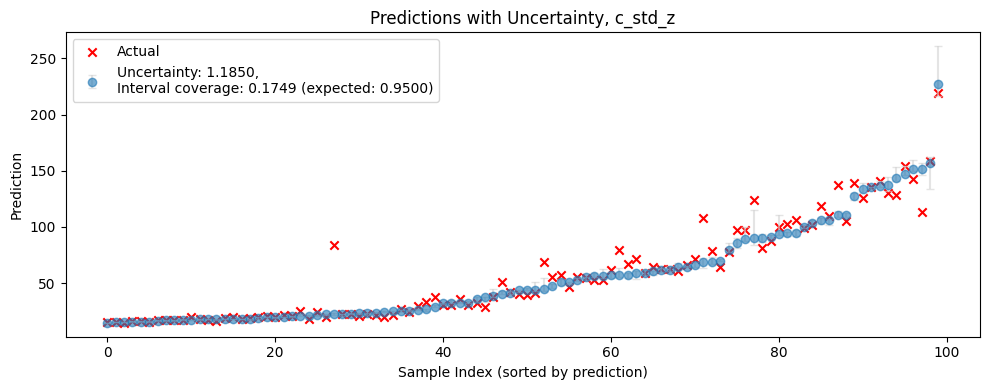

0:	learn: 1.6424483	test: 1.5769998	best: 1.5769998 (0)	total: 4.75ms	remaining: 4.75s
100:	learn: 0.5566512	test: 0.5984362	best: 0.5984362 (100)	total: 442ms	remaining: 3.93s
200:	learn: 0.4340815	test: 0.4944241	best: 0.4944241 (200)	total: 900ms	remaining: 3.58s
300:	learn: 0.4092217	test: 0.4762004	best: 0.4760464 (299)	total: 1.4s	remaining: 3.24s
400:	learn: 0.3930634	test: 0.4700378	best: 0.4700017 (397)	total: 1.89s	remaining: 2.82s
500:	learn: 0.3795696	test: 0.4666601	best: 0.4666386 (491)	total: 2.36s	remaining: 2.35s
600:	learn: 0.3690071	test: 0.4657066	best: 0.4656289 (563)	total: 2.84s	remaining: 1.89s
700:	learn: 0.3602435	test: 0.4653475	best: 0.4653475 (700)	total: 3.32s	remaining: 1.42s
800:	learn: 0.3527293	test: 0.4648871	best: 0.4648216 (793)	total: 3.8s	remaining: 944ms
900:	learn: 0.3458828	test: 0.4651584	best: 0.4647542 (846)	total: 4.27s	remaining: 470ms
bestTest = 0.4647542054
bestIteration = 846
Shrink model to first 847 iterations.


Fitting bootstrap models:   0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 1.6416578	test: 1.5769319	best: 1.5769319 (0)	total: 5.41ms	remaining: 5.41s
100:	learn: 0.5552020	test: 0.5993608	best: 0.5993608 (100)	total: 480ms	remaining: 4.28s
200:	learn: 0.4336202	test: 0.4952980	best: 0.4952980 (200)	total: 960ms	remaining: 3.81s
300:	learn: 0.4078046	test: 0.4760414	best: 0.4760414 (300)	total: 1.47s	remaining: 3.4s
400:	learn: 0.3913270	test: 0.4690511	best: 0.4690511 (400)	total: 1.97s	remaining: 2.94s
500:	learn: 0.3789311	test: 0.4663476	best: 0.4663067 (496)	total: 2.46s	remaining: 2.45s
600:	learn: 0.3684223	test: 0.4651169	best: 0.4651169 (600)	total: 2.95s	remaining: 1.96s
700:	learn: 0.3596375	test: 0.4645542	best: 0.4640752 (671)	total: 3.44s	remaining: 1.47s
800:	learn: 0.3519729	test: 0.4637037	best: 0.4636333 (793)	total: 3.94s	remaining: 979ms
900:	learn: 0.3454356	test: 0.4636869	best: 0.4636144 (828)	total: 4.45s	remaining: 489ms


Fitting bootstrap models:  10%|█         | 1/10 [00:09<01:22,  9.15s/it]

999:	learn: 0.3395773	test: 0.4634254	best: 0.4634200 (962)	total: 4.94s	remaining: 0us
bestTest = 0.46342001
bestIteration = 962
Shrink model to first 963 iterations.
0:	learn: 1.6412209	test: 1.5766438	best: 1.5766438 (0)	total: 5.33ms	remaining: 5.32s
100:	learn: 0.5559471	test: 0.5994277	best: 0.5994277 (100)	total: 481ms	remaining: 4.28s
200:	learn: 0.4343153	test: 0.4961272	best: 0.4961272 (200)	total: 976ms	remaining: 3.88s
300:	learn: 0.4084516	test: 0.4767644	best: 0.4767644 (300)	total: 1.49s	remaining: 3.46s
400:	learn: 0.3926109	test: 0.4702830	best: 0.4702336 (398)	total: 2.01s	remaining: 3s
500:	learn: 0.3797360	test: 0.4677502	best: 0.4676636 (492)	total: 2.51s	remaining: 2.5s
600:	learn: 0.3691919	test: 0.4666604	best: 0.4666429 (593)	total: 3.02s	remaining: 2s
700:	learn: 0.3600819	test: 0.4658293	best: 0.4656214 (669)	total: 3.52s	remaining: 1.5s
800:	learn: 0.3524701	test: 0.4651062	best: 0.4651062 (800)	total: 4.03s	remaining: 1s
900:	learn: 0.3454111	test: 0.465335

Fitting bootstrap models:  20%|██        | 2/10 [00:18<01:12,  9.06s/it]

0:	learn: 1.6420496	test: 1.5766554	best: 1.5766554 (0)	total: 5.36ms	remaining: 5.35s
100:	learn: 0.5568459	test: 0.5978030	best: 0.5978030 (100)	total: 464ms	remaining: 4.13s
200:	learn: 0.4349353	test: 0.4932331	best: 0.4932331 (200)	total: 938ms	remaining: 3.73s
300:	learn: 0.4088641	test: 0.4768283	best: 0.4768283 (300)	total: 1.44s	remaining: 3.35s
400:	learn: 0.3921806	test: 0.4700561	best: 0.4700561 (400)	total: 1.95s	remaining: 2.91s
500:	learn: 0.3790067	test: 0.4664135	best: 0.4664135 (500)	total: 2.44s	remaining: 2.43s
600:	learn: 0.3684425	test: 0.4658291	best: 0.4658291 (600)	total: 2.93s	remaining: 1.94s
700:	learn: 0.3593670	test: 0.4648800	best: 0.4648403 (690)	total: 3.42s	remaining: 1.46s
800:	learn: 0.3519178	test: 0.4642883	best: 0.4639925 (758)	total: 3.92s	remaining: 975ms
900:	learn: 0.3450985	test: 0.4636029	best: 0.4633704 (893)	total: 4.42s	remaining: 486ms


Fitting bootstrap models:  30%|███       | 3/10 [00:27<01:03,  9.12s/it]

999:	learn: 0.3393356	test: 0.4633772	best: 0.4632614 (989)	total: 4.92s	remaining: 0us
bestTest = 0.463261447
bestIteration = 989
Shrink model to first 990 iterations.
0:	learn: 1.6424062	test: 1.5767489	best: 1.5767489 (0)	total: 5.19ms	remaining: 5.19s
100:	learn: 0.5565152	test: 0.5983222	best: 0.5983222 (100)	total: 476ms	remaining: 4.24s
200:	learn: 0.4340285	test: 0.4942471	best: 0.4942471 (200)	total: 958ms	remaining: 3.81s
300:	learn: 0.4083958	test: 0.4761910	best: 0.4761910 (300)	total: 1.47s	remaining: 3.41s
400:	learn: 0.3915216	test: 0.4705631	best: 0.4702750 (398)	total: 1.98s	remaining: 2.95s
500:	learn: 0.3790167	test: 0.4678957	best: 0.4678903 (499)	total: 2.48s	remaining: 2.47s
600:	learn: 0.3684880	test: 0.4672003	best: 0.4670131 (581)	total: 2.98s	remaining: 1.98s
700:	learn: 0.3601628	test: 0.4666059	best: 0.4664428 (679)	total: 3.48s	remaining: 1.48s
800:	learn: 0.3526226	test: 0.4661204	best: 0.4659520 (795)	total: 3.98s	remaining: 988ms


Fitting bootstrap models:  40%|████      | 4/10 [00:36<00:53,  9.00s/it]

bestTest = 0.4659520071
bestIteration = 795
Shrink model to first 796 iterations.
0:	learn: 1.6420041	test: 1.5768609	best: 1.5768609 (0)	total: 5.35ms	remaining: 5.34s
100:	learn: 0.5560037	test: 0.6004763	best: 0.6004763 (100)	total: 470ms	remaining: 4.18s
200:	learn: 0.4337880	test: 0.4975859	best: 0.4975859 (200)	total: 955ms	remaining: 3.79s
300:	learn: 0.4083237	test: 0.4784317	best: 0.4784317 (300)	total: 1.47s	remaining: 3.42s
400:	learn: 0.3913525	test: 0.4733463	best: 0.4733404 (399)	total: 1.97s	remaining: 2.94s
500:	learn: 0.3784164	test: 0.4705311	best: 0.4705311 (500)	total: 2.46s	remaining: 2.46s
600:	learn: 0.3681269	test: 0.4691786	best: 0.4691786 (600)	total: 2.96s	remaining: 1.96s
700:	learn: 0.3597705	test: 0.4678541	best: 0.4678541 (700)	total: 3.45s	remaining: 1.47s
800:	learn: 0.3523626	test: 0.4678297	best: 0.4678037 (723)	total: 3.93s	remaining: 977ms
900:	learn: 0.3456751	test: 0.4675899	best: 0.4673454 (890)	total: 4.42s	remaining: 485ms
999:	learn: 0.3397504

Fitting bootstrap models:  50%|█████     | 5/10 [00:45<00:45,  9.11s/it]

0:	learn: 1.6445186	test: 1.5767485	best: 1.5767485 (0)	total: 5.15ms	remaining: 5.15s
100:	learn: 0.5581790	test: 0.5975478	best: 0.5975478 (100)	total: 462ms	remaining: 4.11s
200:	learn: 0.4361486	test: 0.4950860	best: 0.4950860 (200)	total: 937ms	remaining: 3.72s
300:	learn: 0.4108496	test: 0.4769671	best: 0.4769569 (297)	total: 1.44s	remaining: 3.35s
400:	learn: 0.3942086	test: 0.4698169	best: 0.4698169 (400)	total: 1.93s	remaining: 2.89s
500:	learn: 0.3804235	test: 0.4666691	best: 0.4665765 (495)	total: 2.41s	remaining: 2.4s
600:	learn: 0.3702439	test: 0.4658720	best: 0.4658301 (599)	total: 2.9s	remaining: 1.93s
700:	learn: 0.3612274	test: 0.4654464	best: 0.4654464 (700)	total: 3.4s	remaining: 1.45s
800:	learn: 0.3533563	test: 0.4655474	best: 0.4649990 (753)	total: 3.9s	remaining: 968ms


Fitting bootstrap models:  60%|██████    | 6/10 [00:53<00:35,  8.91s/it]

bestTest = 0.4649989842
bestIteration = 753
Shrink model to first 754 iterations.
0:	learn: 1.6427026	test: 1.5768577	best: 1.5768577 (0)	total: 5.15ms	remaining: 5.15s
100:	learn: 0.5571870	test: 0.5980998	best: 0.5980998 (100)	total: 469ms	remaining: 4.17s
200:	learn: 0.4349885	test: 0.4960500	best: 0.4960500 (200)	total: 950ms	remaining: 3.77s
300:	learn: 0.4090618	test: 0.4807536	best: 0.4803690 (297)	total: 1.47s	remaining: 3.41s
400:	learn: 0.3924621	test: 0.4755359	best: 0.4755359 (400)	total: 1.99s	remaining: 2.96s
500:	learn: 0.3802616	test: 0.4731087	best: 0.4730152 (493)	total: 2.49s	remaining: 2.48s
600:	learn: 0.3695295	test: 0.4716870	best: 0.4716326 (597)	total: 3s	remaining: 1.99s
700:	learn: 0.3607668	test: 0.4714431	best: 0.4713929 (698)	total: 3.5s	remaining: 1.49s
800:	learn: 0.3533045	test: 0.4712963	best: 0.4711210 (743)	total: 4s	remaining: 994ms


Fitting bootstrap models:  70%|███████   | 7/10 [01:02<00:26,  8.82s/it]

bestTest = 0.4711210216
bestIteration = 743
Shrink model to first 744 iterations.
0:	learn: 1.6424234	test: 1.5770771	best: 1.5770771 (0)	total: 5.21ms	remaining: 5.21s
100:	learn: 0.5569304	test: 0.6015716	best: 0.6015716 (100)	total: 473ms	remaining: 4.21s
200:	learn: 0.4351316	test: 0.4991846	best: 0.4991846 (200)	total: 952ms	remaining: 3.79s
300:	learn: 0.4096233	test: 0.4822257	best: 0.4822257 (300)	total: 1.47s	remaining: 3.41s
400:	learn: 0.3930887	test: 0.4777861	best: 0.4777513 (399)	total: 1.98s	remaining: 2.95s
500:	learn: 0.3801086	test: 0.4761194	best: 0.4760548 (497)	total: 2.48s	remaining: 2.47s
600:	learn: 0.3696146	test: 0.4745615	best: 0.4745208 (598)	total: 2.98s	remaining: 1.98s
700:	learn: 0.3605846	test: 0.4730889	best: 0.4730622 (695)	total: 3.48s	remaining: 1.49s
800:	learn: 0.3528826	test: 0.4725456	best: 0.4724201 (778)	total: 3.98s	remaining: 989ms
900:	learn: 0.3464330	test: 0.4718623	best: 0.4717864 (896)	total: 4.47s	remaining: 491ms


Fitting bootstrap models:  80%|████████  | 8/10 [01:11<00:17,  8.95s/it]

999:	learn: 0.3401933	test: 0.4715005	best: 0.4714875 (994)	total: 4.95s	remaining: 0us
bestTest = 0.4714875481
bestIteration = 994
Shrink model to first 995 iterations.
0:	learn: 1.6427041	test: 1.5770800	best: 1.5770800 (0)	total: 5.15ms	remaining: 5.14s
100:	learn: 0.5561037	test: 0.6003166	best: 0.6003166 (100)	total: 469ms	remaining: 4.17s
200:	learn: 0.4343265	test: 0.4964215	best: 0.4964215 (200)	total: 950ms	remaining: 3.77s
300:	learn: 0.4081418	test: 0.4799200	best: 0.4799200 (300)	total: 1.47s	remaining: 3.42s
400:	learn: 0.3916584	test: 0.4737448	best: 0.4737448 (400)	total: 2s	remaining: 2.98s
500:	learn: 0.3788802	test: 0.4732402	best: 0.4731187 (497)	total: 2.5s	remaining: 2.49s
600:	learn: 0.3686576	test: 0.4724576	best: 0.4724557 (591)	total: 3.01s	remaining: 2s
700:	learn: 0.3601370	test: 0.4719371	best: 0.4718548 (675)	total: 3.51s	remaining: 1.5s
bestTest = 0.4718548266
bestIteration = 675
Shrink model to first 676 iterations.


Fitting bootstrap models:  90%|█████████ | 9/10 [01:20<00:08,  8.77s/it]

0:	learn: 1.6419568	test: 1.5766331	best: 1.5766331 (0)	total: 5.07ms	remaining: 5.06s
100:	learn: 0.5574501	test: 0.5982783	best: 0.5982783 (100)	total: 451ms	remaining: 4.02s
200:	learn: 0.4354527	test: 0.4945221	best: 0.4945221 (200)	total: 932ms	remaining: 3.71s
300:	learn: 0.4099245	test: 0.4782746	best: 0.4782746 (300)	total: 1.45s	remaining: 3.36s
400:	learn: 0.3933033	test: 0.4719689	best: 0.4717924 (396)	total: 1.96s	remaining: 2.93s
500:	learn: 0.3809269	test: 0.4710166	best: 0.4710137 (499)	total: 2.47s	remaining: 2.46s
600:	learn: 0.3703962	test: 0.4696513	best: 0.4696431 (599)	total: 2.97s	remaining: 1.97s
700:	learn: 0.3605379	test: 0.4692476	best: 0.4692476 (700)	total: 3.46s	remaining: 1.48s
800:	learn: 0.3527078	test: 0.4683013	best: 0.4682850 (796)	total: 3.96s	remaining: 983ms
900:	learn: 0.3457216	test: 0.4679293	best: 0.4678166 (893)	total: 4.45s	remaining: 489ms


Fitting bootstrap models: 100%|██████████| 10/10 [01:29<00:00,  8.95s/it]


999:	learn: 0.3396173	test: 0.4674652	best: 0.4673157 (958)	total: 4.95s	remaining: 0us
bestTest = 0.4673156556
bestIteration = 958
Shrink model to first 959 iterations.


Generating bootstrap predictions: 100%|██████████| 10/10 [00:00<00:00, 19.11it/s]


Catboost RMSE: 16.4537
Interval coverage: 0.1378 (expected: 0.9500)


Generating bootstrap predictions: 100%|██████████| 10/10 [00:00<00:00, 692.29it/s]


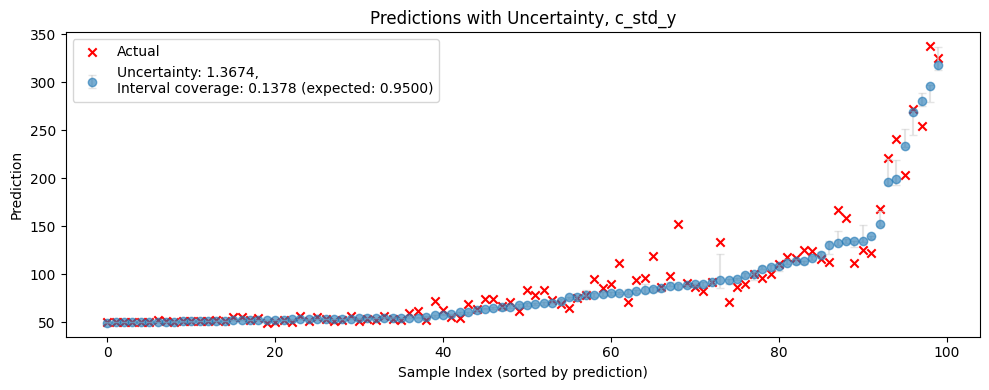

In [95]:
print("Running CatBoost Regression uncertainty estimation...")
for target in y_1.columns:
    params[target].pop("logging_level")
    cb_uncertainty = UncertaintyCbEstimator(params[target], t_preproc,target, n_bootstrap=10)
    cb_uncertainty.fit(X_train_n, y_1[target], X_eval_n, y_eval[target])
    # cb_predictions = rf_uncertainty.predict_with_uncertainty(X_test_n)
    cb_eval = cb_uncertainty.evaluate_uncertainty(X_test_n, y_test[target])

    print(f"Catboost RMSE: {cb_eval['rmse']:.4f}")
    print(f"Interval coverage: {cb_eval['interval_coverage']:.4f} (expected: {cb_eval['expected_coverage']:.4f})")

    # Visualize with a subset of samples for clarity
    cb_uncertainty.visualize_uncertainty(X_test_n, y_test[target], cb_eval, n_samples=100)

## ANN Uncertainty

In [66]:
import os
import re
import logging
from pathlib import Path
from typing import Tuple, List, Dict, Union, Optional
import shap
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [67]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return torch.sqrt(self.mse(y_pred, y_true))


class RegressionNet(nn.Module):
    
    def __init__(self, input_dim: int, hidden1: int = 1024, hidden2: int = 512, hidden3: int = 256, hidden4: int = 64, output_dim: int = 4):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.Mish(),
            nn.Linear(hidden1, hidden2),
            nn.Mish(),
            nn.Linear(hidden2, hidden3),
            nn.Mish(),
            nn.Linear(hidden3, hidden4),
            nn.Mish(),
            nn.Linear(hidden4, output_dim)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


In [68]:
class ModelTrainer:
    def __init__(
        self,
        model: nn.Module,
        criterion: nn.Module = None,
        learning_rate: float = 1e-3,
        device: str = None,
    ):
        assert(torch.cuda.is_available())
        self.device = torch.device('cuda')
        self.model = model.to(self.device)
        self.criterion = criterion if criterion else RMSELoss()
        
        # Adaptive learning rate with ReduceLROnPlateau
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='min', 
            factor=0.5,  # Reduce learning rate by half
            patience=5,  # Wait for 5 epochs without improvement
            min_lr=1e-6,  # Minimum learning rate
            verbose=True
        )
        
    
    def train(
        self,
        X_train: np.ndarray,
        y_train: pd.DataFrame,
        epochs: int = 100,
        batch_size: int = 256,
        validation_data: Tuple[np.ndarray, pd.DataFrame] = None,
        early_stopping_patience: int = None
    ) -> Dict[str, List[float]]:
        # Convert data to tensors
        X_train_tensor = torch.FloatTensor(X_train).to(self.device)
        y_train_tensor = torch.FloatTensor(y_train).to(self.device)
        
        # Create data loader
        dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        # Prepare validation data if provided
        if validation_data:
            X_val, y_val = validation_data
            X_val_tensor = torch.FloatTensor(X_val.to_numpy()).to(self.device)
            y_val_tensor = torch.FloatTensor(y_val.to_numpy()).to(self.device)
        
        # Training metrics
        metrics = {
            'train_loss': [],
            'val_loss': [] if validation_data else None,
            'learning_rates': []
        }
        
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_path = os.path.join('best_model.pth')
        
        # Training loop
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            epoch_loss = 0.0
            
            for batch_X, batch_y in dataloader:
                # Forward pass
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                
                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                epoch_loss += loss.item()
            
            # Calculate average loss for the epoch
            avg_train_loss = epoch_loss / len(dataloader)
            metrics['train_loss'].append(avg_train_loss)
            
            # Log current learning rate
            current_lr = self.optimizer.param_groups[0]['lr']
            metrics['learning_rates'].append(current_lr)
            
            # Validation phase
            if validation_data:
                self.model.eval()
                with torch.no_grad():
                    val_outputs = self.model(X_val_tensor)
                    val_loss = self.criterion(val_outputs, y_val_tensor).item()
                    metrics['val_loss'].append(val_loss)
                
                # Adaptive learning rate adjustment
                self.scheduler.step(val_loss)
                
                # Model checkpointing
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    
                    # Save the best model
                    torch.save({
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'best_val_loss': best_val_loss,
                        'epoch': epoch
                    }, best_model_path)
                else:
                    patience_counter += 1
                
                # Early stopping
                if early_stopping_patience and patience_counter >= early_stopping_patience:
                    break
            
            # Print progress
            if (epoch + 1) % 10 == 0:
                log_msg = f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}'
                if validation_data:
                    log_msg += f', Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}'
                print(log_msg)
        
        return metrics
    
    def evaluate(self, X_test: np.ndarray, y_test: pd.DataFrame) -> Tuple[pd.DataFrame, float]:
        # Load the best model if it exists
        best_model_path = os.path.join('best_model.pth')
        if os.path.exists(best_model_path):
            checkpoint = torch.load(best_model_path, weights_only=True)
            self.model.load_state_dict(checkpoint['model_state_dict'])
        
        self.model.eval()
        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(X_test.to_numpy()).to(self.device)
            y_test_tensor = torch.FloatTensor(y_test.to_numpy()).to(self.device)
            
            test_outputs = self.model(X_test_tensor)
            
            rmse_loss = self.criterion(test_outputs, y_test_tensor).item()
            
            # Convert predictions to DataFrame
            y_pred = pd.DataFrame(test_outputs.cpu().numpy(), columns=y_test.columns)
            
        return y_pred, rmse_loss
    

In [69]:
config = {
        'random_seed': 42,
        'data_path': '/app/nse/ml',
        'features_filename': 'features_full.csv',
        'targets_filename': 'target_full.csv',
        'model_params': {
            'input_dim': 9,
            "hidden1": 16,
            'hidden2': 8,
            'hidden3': 4,
            'hidden4': 2,
            'output_dim': 1
        },
        'training_params': {
            'learning_rate': 1e-4,  # Increased from 1e-4
            'epochs': 2,  # Increased from 50
            'batch_size': 6144,
            'early_stopping_patience': 20
        },
        'output_dir': './outputs_16_03_2025',
        'model_checkpoints_dir': './model_checkpoints_16_03_2025'
    }

In [70]:
torch.manual_seed(config['random_seed'])
np.random.seed(config['random_seed'])

In [ ]:
class UncertaintyMLPEstimator:
    def __init__(self, config, target_transformer, target_name, n_bootstrap=100, alpha=0.05, random_state=42):
        self.n_bootstrap = n_bootstrap
        self.alpha = alpha
        self.random_state = random_state
        self.models = []
        self.base_model = None
        self.target_transformer = target_transformer
        self.target_name = target_name
        self.config = config
        self.base_model = RegressionNet(**self.config['model_params'])

    def fit(self, X, y, X_eval, y_eval):
        y = np.array(y)
        X = np.array(X)

        self.base_trainer = ModelTrainer(self.base_model)

        metrics = self.base_trainer.train(
            X, y,
            epochs=self.config['training_params']['epochs'],
            batch_size=self.config['training_params']['batch_size'],
            # validation_data=(data['X_val'], data['y_val']),
            validation_data=(X_eval, y_eval),
            early_stopping_patience=self.config['training_params']['early_stopping_patience']
        )
        
        # Bootstrap sampling for uncertainty estimation
        n_samples = X.shape[0]
        self.models = []
        
        for i in tqdm(range(self.n_bootstrap), desc="Fitting bootstrap models"):
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            
            # Create and fit a new model
            model = RegressionNet(**self.config['model_params'])
            trainer = ModelTrainer(model)

            metrics = trainer.train(
                X_bootstrap, y_bootstrap,
                epochs=self.config['training_params']['epochs'],
                batch_size=self.config['training_params']['batch_size'],
                # validation_data=(data['X_val'], data['y_val']),
                validation_data=(X_eval, y_eval),
                early_stopping_patience=config['training_params']['early_stopping_patience']
            )
            self.models.append(trainer)
        
        return self
    
   
    def predict_with_uncertainty(self, X, y):
        result = {}
        
        # Base model prediction
        y_pred_tmp, rmse_loss = self.base_trainer.evaluate(X, y)
        # y_pred_tmp = pd.DataFrame(data=y_pred_tmp, columns=[self.target_name])
        self.target_transformer.inverse_transform(y_pred_tmp)
        result['prediction'] = np.array(y_pred_tmp[self.target_name])

        # Bootstrap-based uncertainty
        bootstrap_predictions = []
        for trainers in tqdm(self.models, desc="Generating bootstrap predictions"):
            
            y_pred_tmp, rmse_loss = trainers.evaluate(X, y)
            # y_pred_tmp = pd.DataFrame(data=y_pred_tmp, columns=[self.target_name])
            self.target_transformer.inverse_transform(y_pred_tmp)
            result['prediction'] = np.array(y_pred_tmp[self.target_name])
            bootstrap_predictions.append(np.array(y_pred_tmp[self.target_name]))

        bootstrap_predictions = np.array(bootstrap_predictions)
        
        
        result['mean'] = np.mean(bootstrap_predictions, axis=0)
        result['std'] = np.std(bootstrap_predictions, axis=0)
        lower_percentile = 100 * self.alpha / 2
        upper_percentile = 100 * (1 - self.alpha / 2)
        result['lower_bound'] = np.percentile(bootstrap_predictions, lower_percentile, axis=0)
        result['upper_bound'] = np.percentile(bootstrap_predictions, upper_percentile, axis=0)
        
        # tree_predictions = []
        # for tree in self.base_model.estimators_:
        #     tree_predictions.append(tree.predict(X))
        # tree_predictions = np.array(tree_predictions)
        # result['tree_variance'] = np.var(tree_predictions, axis=0)
        
        
        return result
    
    def evaluate_uncertainty(self, X_test, y_test):
        predictions = self.predict_with_uncertainty(X_test, y_test)
        
        eval_results = {}
        y_test = np.array(np.squeeze(y_test.to_numpy()))
        # Evaluate prediction intervals
        y_test_bigger = y_test >= predictions['lower_bound']
        y_test_smaller = y_test <= predictions['upper_bound'] 
        in_interval = y_test_bigger * y_test_smaller 
        eval_results['interval_coverage'] = np.mean(in_interval)
        eval_results['expected_coverage'] = 1 - self.alpha
        # Calculate RMSE
        eval_results['rmse'] = np.sqrt(mean_squared_error(y_test, predictions['prediction']))
        eval_results['std_mean'] = np.mean(predictions["std"])
        
        # Calculate uncertainty calibration for regression
        # Sort predictions by uncertainty (std)
        # sorted_indices = np.argsort(predictions['std'])
        # sorted_errors = np.abs(y_test - predictions['prediction'])[sorted_indices]
        
        # # Divide into bins and calculate average error in each bin
        # n_bins = 10
        # bin_size = len(sorted_indices) // n_bins
        # bin_errors = []
        # bin_stds = []
        
        # for i in range(n_bins):
        #     start_idx = i * bin_size
        #     end_idx = (i + 1) * bin_size if i < n_bins - 1 else len(sorted_indices)
        #     bin_errors.append(np.mean(sorted_errors[start_idx:end_idx]))
        #     bin_stds.append(np.mean(predictions['std'][sorted_indices[start_idx:end_idx]]))
        
        # eval_results['bin_errors'] = bin_errors
        # eval_results['bin_stds'] = bin_stds
        
        return eval_results
    
    def visualize_uncertainty(self, X_test, y_test=None, m_eval=None, n_samples=None):
        y_test.reset_index(inplace=True, drop=True)
        X_test.reset_index(inplace=True, drop=True)
        if n_samples is not None and n_samples < X_test.shape[0]:
            indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
            X_test_subset = X_test.loc[indices]
            y_test_subset = y_test.loc[indices] if y_test is not None else None
        else:
            X_test_subset = X_test
            y_test_subset = y_test
        
        predictions = self.predict_with_uncertainty(X_test_subset, y_test_subset)
        
        
        # Sort by prediction for clearer visualization
        sort_idx = np.argsort(predictions['prediction'])
        
        plt.figure(figsize=(10, 4))
        plt.errorbar(
            np.arange(len(sort_idx)),
            predictions['prediction'][sort_idx],
            yerr=[
                np.abs(predictions['prediction'][sort_idx] - predictions['lower_bound'][sort_idx]),
                np.abs(predictions['upper_bound'][sort_idx] - predictions['prediction'][sort_idx])
            ],
            fmt='o', alpha=0.6, ecolor='lightgray', capsize=3,
            label = f'Uncertainty: {m_eval["std_mean"]:.8f},\nInterval coverage: {m_eval["interval_coverage"]:.4f} (expected: {m_eval["expected_coverage"]:.4f})'
        )
        y_test_subset.reset_index(inplace=True, drop=True)
        if y_test_subset is not None:
            plt.scatter(np.arange(len(sort_idx)), y_test_subset.loc[sort_idx], 
                        c='red', marker='x', label='Actual')
        
        plt.xlabel('Sample Index (sorted by prediction)')
        plt.ylabel('Prediction')
        plt.title(f'Predictions with Uncertainty, {self.target_name}')

        if y_test_subset is not None:
            plt.legend()
        plt.tight_layout()
        plt.show()
            

    
    def save(self, filename):
        """Save the model and related objects"""
        joblib.dump(self, filename)
    
    @classmethod
    def load(cls, filename):
        """Load a saved model"""
        return joblib.load(filename)

Running ANN uncertainty estimation...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:61: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Generating bootstrap predictions: 100%|██████████| 1/1 [00:00<00:00, 29.62it/s]


MLP RMSE: 44.3297
Interval coverage: 0.0000 (expected: 0.9500)


Generating bootstrap predictions: 100%|██████████| 1/1 [00:00<00:00, 152.54it/s]


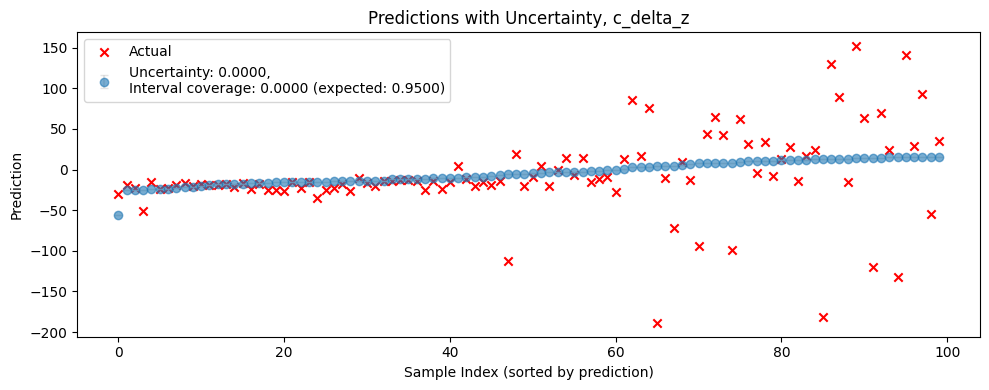

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:61: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 

In [81]:
print("Running ANN uncertainty estimation...")
X_train_n_pd = pd.DataFrame(X_train_n, columns=X_train.columns)
X_eval_n_pd = pd.DataFrame(X_eval_n, columns=X_train.columns)
X_test_n_pd = pd.DataFrame(X_test_n, columns=X_train.columns)

for target in y_1.columns:
    nn_uncertainty = UncertaintyMLPEstimator(config, t_preproc,target, n_bootstrap=1)
    nn_uncertainty.fit(X_train_n_pd, pd.DataFrame(y_1[target], columns=[target]), X_eval_n_pd, pd.DataFrame(y_eval[target], columns=[target]))
    # cb_predictions = rf_uncertainty.predict_with_uncertainty(X_test_n)
    nn_eval = nn_uncertainty.evaluate_uncertainty(X_test_n_pd, pd.DataFrame(np.array(y_test[target]),columns=[target]))

    print(f"MLP RMSE: {nn_eval['rmse']:.4f}")
    print(f"Interval coverage: {nn_eval['interval_coverage']:.4f} (expected: {nn_eval['expected_coverage']:.4f})")

    # Visualize with a subset of samples for clarity
    nn_uncertainty.visualize_uncertainty(X_test_n_pd, pd.DataFrame(np.array(y_test[target]), columns=[target]), nn_eval, n_samples=100)